#### File used to compare the losses used in DEEPLAB:
1. Cross Entropy
2. 0.5 * Cross Entropy +  0.5* Lovász-Softmax

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


def analyze_and_plot_miou_runtime(csv_label_list):
    """
    Carica più CSV e visualizza:
    - Curve val_mIoU (con eventuale punto finale)
    - Scatter mIoU vs Tempo Totale di Training

    Parametri:
    ----------
    csv_label_list : list of tuples
        Lista di tuple (csv_path, label), dove 'label' è il nome mostrato nei grafici.

    Ritorna:
    --------
    results : list of dict
        Ogni dict ha chiavi 'label', 'miou', 'runtime', 'df_extended'
    """

    results = []
    plt.figure(figsize=(14, 7))

    for csv_path, label in csv_label_list:
        df = pd.read_csv(csv_path)

        cols = ['epoch', 'val_mIoU']
        if 'Runtime' in df.columns:
            cols.append('Runtime')

        df_clean = df[cols].dropna().sort_values(by='epoch')
        df_extended = df_clean[['epoch', 'val_mIoU']].copy()

        # Punto finale se disponibile
        show_final = False
        if 'val_mIoU_final' in df.columns and df['val_mIoU_final'].notna().any():
            final_row = df[['epoch', 'val_mIoU_final']].dropna().sort_values(by='epoch').iloc[-1]
            max_epoch = df_extended['epoch'].max()

            if max_epoch < final_row['epoch']:
                final_point = pd.DataFrame([{
                    'epoch': final_row['epoch'],
                    'val_mIoU': final_row['val_mIoU_final'],
                }])
                df_extended = pd.concat([df_extended, final_point], ignore_index=True)
            else:
                df_extended.loc[df_extended['epoch'].idxmax(), 'val_mIoU'] = final_row['val_mIoU_final']

            show_final = True

        # Plot curva
        line, = plt.plot(df_extended['epoch'], df_extended['val_mIoU'],
                         label=label, linestyle='-', marker='o')
        if show_final:
            plt.text(final_row['epoch'] + 0.3, final_row['val_mIoU_final'],
                     f"{final_row['val_mIoU_final']:.2f}% (final)",
                     color=line.get_color(), ha='left', va='bottom', fontsize=9)

        # Calcolo runtime e mIoU finale
        total_runtime_min = df_clean['Runtime'].sum() / 60 if 'Runtime' in df_clean.columns else None

        epoch_50_row = df[df['epoch'] == 50]
        if not epoch_50_row.empty:
            val_miou_final_50 = epoch_50_row.iloc[0].get('val_mIoU_final', None)
            if pd.notna(val_miou_final_50):
                final_miou = val_miou_final_50
            else:
                final_miou = epoch_50_row.iloc[0]['val_mIoU']
        else:
            final_miou = df_extended.iloc[-1]['val_mIoU']

        results.append({
            'label': label,
            'miou': final_miou,
            'runtime': total_runtime_min,
            'df_extended': df_extended
        })

    # Mostra primo plot (curve)
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.title('Validation mIoU Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Secondo plot: mIoU vs Runtime
    plt.figure(figsize=(10, 6))
    runtimes = [r['runtime'] for r in results]
    mious = [r['miou'] for r in results]
    labels = [r['label'] for r in results]

    plt.scatter(runtimes, mious, color='blue')

    offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5
    offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05

    for i, label in enumerate(labels):
        plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
                 f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%",
                 fontsize=9, ha='left', va='bottom')

    plt.xlabel('Total Training Time (minutes)')
    plt.ylabel('Final Validation mIoU (%)')
    plt.title('Trade-off: mIoU vs. Total Training Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results


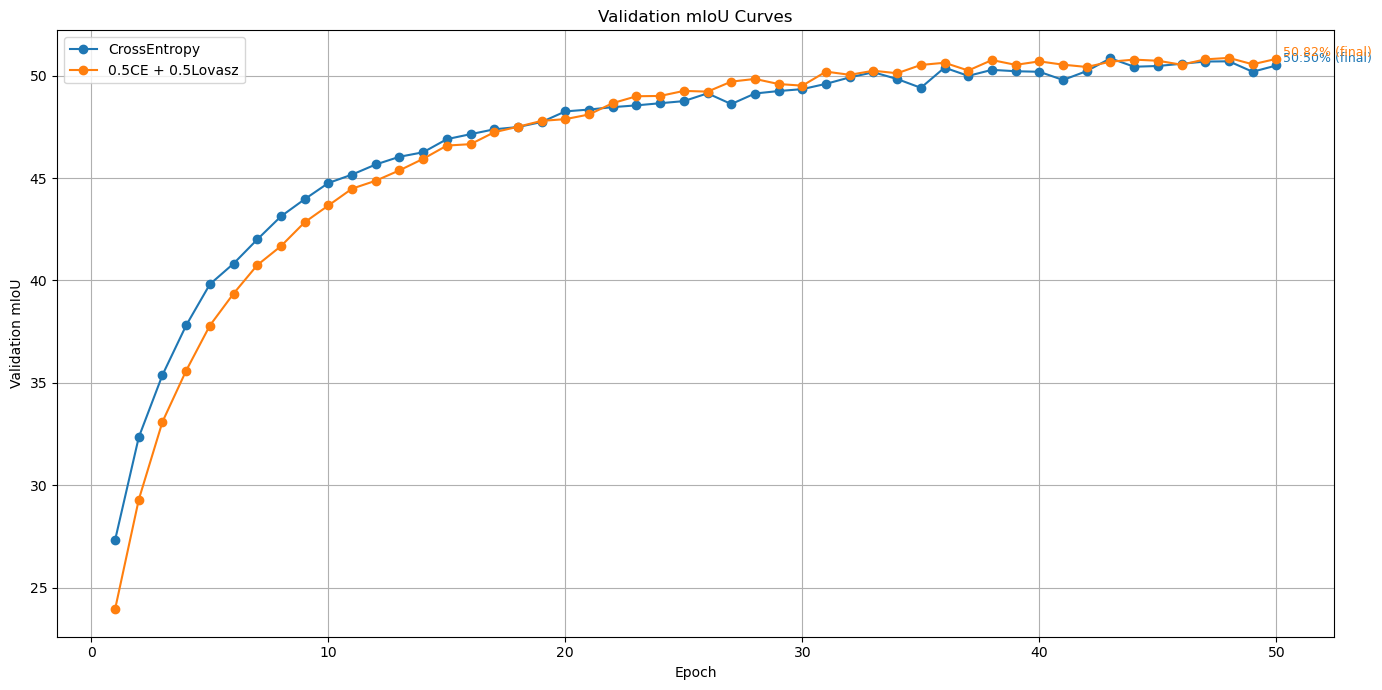

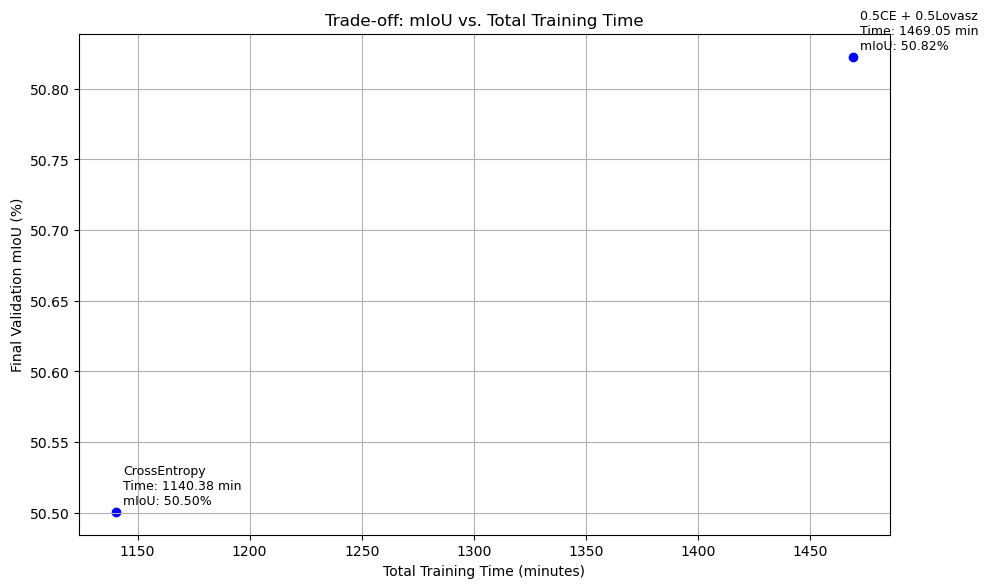

In [15]:
results = analyze_and_plot_miou_runtime([
    ("wandb_export_2025-05-17T16_57_05.534+02_00.csv", "CrossEntropy"),
    ("wandb_export_2025-05-15T16_12_48.823+02_00.csv", "0.5CE + 0.5Lovasz"),
])


NON HA SENSO CONSDIERA RUNTIME PERCHE PER CROSS ENTROPY DA 26 IN POI HO USATO KAGGLE GPU P100 CHE CI METTEVA CIRCA 11 MINUTI IN MENO A EPOCA.
QUINDI SE FACCIO 1140.38 + 25* 10.8 = 1410 (un po meno).
COMUNQUE RISULTATI SIMILI.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_plot_miou_runtime(csv_label_list):
    """
    Carica più CSV e visualizza:
    - Curve val_mIoU (con eventuale punto finale)
    - Scatter mIoU vs Tempo Totale di Training
    - Curve train_loss per epoca

    Parametri:
    ----------
    csv_label_list : list of tuples
        Lista di tuple (csv_path, label), dove 'label' è il nome mostrato nei grafici.

    Ritorna:
    --------
    results : list of dict
        Ogni dict ha chiavi 'label', 'miou', 'runtime', 'df_extended'
    """

    results = []
    plt.figure(figsize=(14, 7))

    for csv_path, label in csv_label_list:
        df = pd.read_csv(csv_path)

        cols = ['epoch', 'val_mIoU']
        if 'Runtime' in df.columns:
            cols.append('Runtime')
        if 'train_loss' in df.columns:
            cols.append('train_loss')

        df_clean = df[cols].dropna(subset=['epoch']).sort_values(by='epoch')
        df_extended = df_clean[['epoch', 'val_mIoU']].copy()

        # Punto finale se disponibile
        show_final = False
        if 'val_mIoU_final' in df.columns and df['val_mIoU_final'].notna().any():
            final_row = df[['epoch', 'val_mIoU_final']].dropna().sort_values(by='epoch').iloc[-1]
            max_epoch = df_extended['epoch'].max()

            if max_epoch < final_row['epoch']:
                final_point = pd.DataFrame([{
                    'epoch': final_row['epoch'],
                    'val_mIoU': final_row['val_mIoU_final'],
                }])
                df_extended = pd.concat([df_extended, final_point], ignore_index=True)
            else:
                df_extended.loc[df_extended['epoch'].idxmax(), 'val_mIoU'] = final_row['val_mIoU_final']

            show_final = True

        # Plot curva val_mIoU
        line, = plt.plot(df_extended['epoch'], df_extended['val_mIoU'],
                         label=label, linestyle='-', marker='o')
        if show_final:
            plt.text(final_row['epoch'] + 0.3, final_row['val_mIoU_final'],
                     f"{final_row['val_mIoU_final']:.2f}% (final)",
                     color=line.get_color(), ha='left', va='bottom', fontsize=9)

        # Calcolo runtime e mIoU finale
        total_runtime_min = df_clean['Runtime'].sum() / 60 if 'Runtime' in df_clean.columns else None

        epoch_50_row = df[df['epoch'] == 50]
        if not epoch_50_row.empty:
            val_miou_final_50 = epoch_50_row.iloc[0].get('val_mIoU_final', None)
            if pd.notna(val_miou_final_50):
                final_miou = val_miou_final_50
            else:
                final_miou = epoch_50_row.iloc[0]['val_mIoU']
        else:
            final_miou = df_extended.iloc[-1]['val_mIoU']

        results.append({
            'label': label,
            'miou': final_miou,
            'runtime': total_runtime_min,
            'df_extended': df_extended,
            'train_loss': df_clean[['epoch', 'train_loss']] if 'train_loss' in df_clean.columns else None
        })

    # Mostra primo plot (val_mIoU)
    plt.xlabel('Epoch')
    plt.ylabel('Validation mIoU')
    plt.title('Validation mIoU Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Secondo plot: mIoU vs Runtime
    plt.figure(figsize=(10, 6))
    runtimes = [r['runtime'] for r in results]
    mious = [r['miou'] for r in results]
    labels = [r['label'] for r in results]

    plt.scatter(runtimes, mious, color='blue')

    offset_x = (max(runtimes) - min(runtimes)) * 0.01 if len(runtimes) > 1 else 0.5
    offset_y = (max(mious) - min(mious)) * 0.01 if len(mious) > 1 else 0.05

    for i, label in enumerate(labels):
        plt.text(runtimes[i] + offset_x, mious[i] + offset_y,
                 f"{label}\nTime: {runtimes[i]:.2f} min\nmIoU: {mious[i]:.2f}%",
                 fontsize=9, ha='left', va='bottom')

    plt.xlabel('Total Training Time (minutes)')
    plt.ylabel('Final Validation mIoU (%)')
    plt.title('Trade-off: mIoU vs. Total Training Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Terzo plot: train_loss
    plt.figure(figsize=(14, 7))
    for res in results:
        if res['train_loss'] is not None:
            plt.plot(res['train_loss']['epoch'], res['train_loss']['train_loss'],
                     label=res['label'], linestyle='-', marker='x')

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results


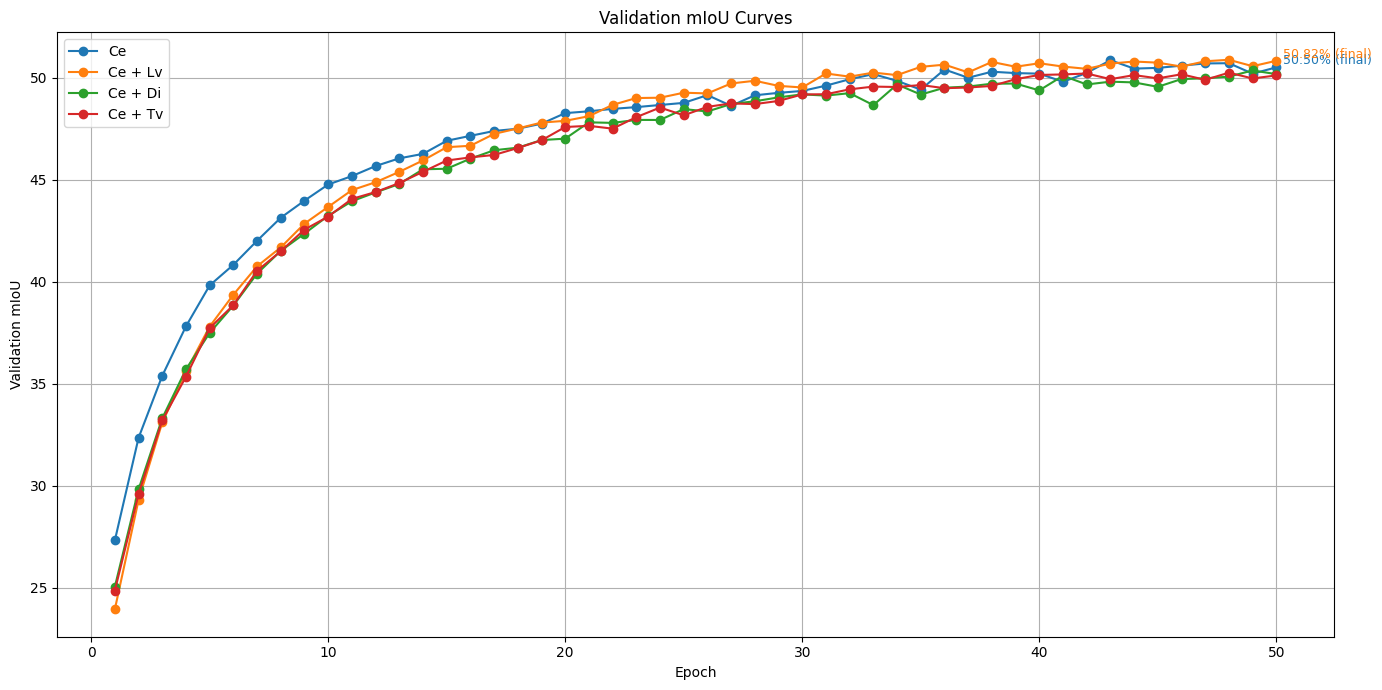

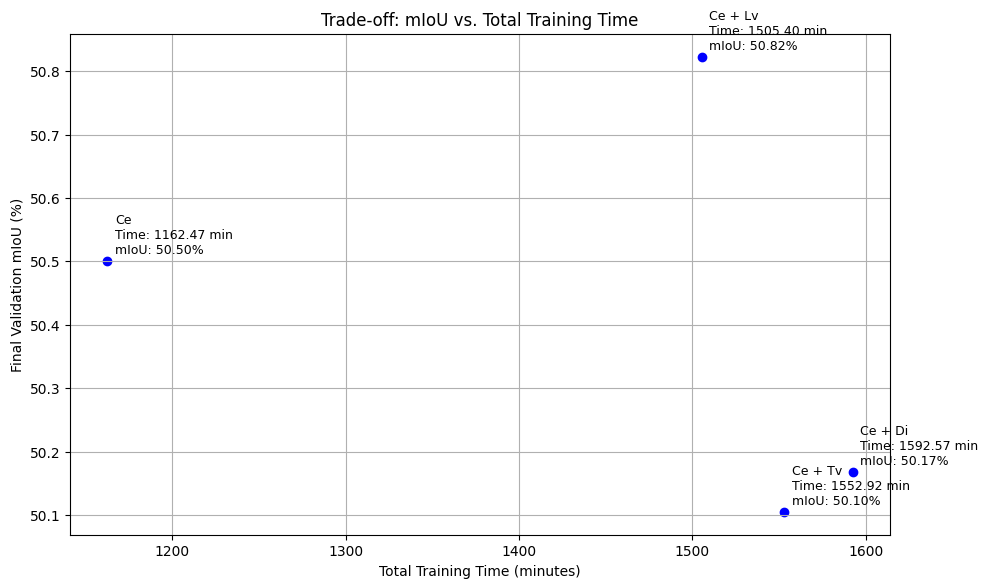

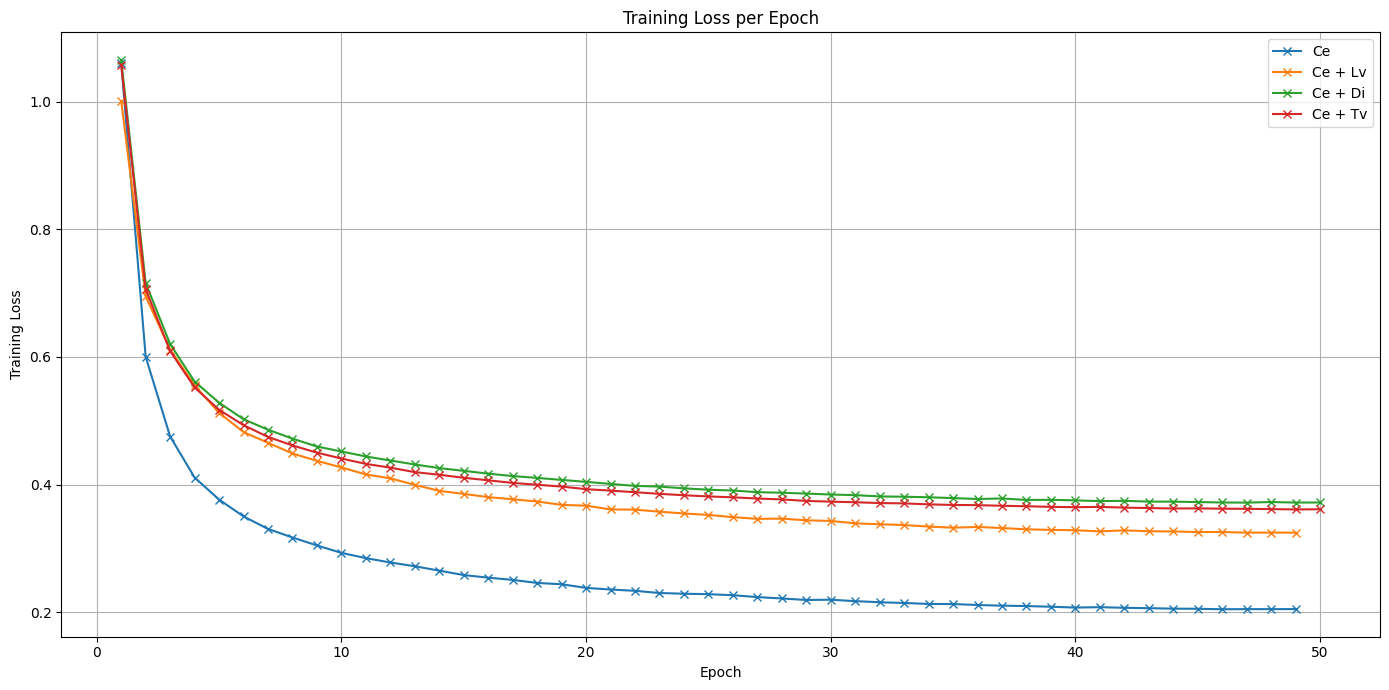

[{'label': 'Ce',
  'miou': np.float64(50.50062711042415),
  'runtime': np.float64(1162.4666666666667),
  'df_extended':     epoch   val_mIoU
  49      1  27.321414
  48      2  32.344314
  47      3  35.386878
  46      4  37.809671
  45      5  39.816443
  44      6  40.825314
  43      7  42.004242
  42      8  43.132181
  41      9  43.969703
  40     10  44.760406
  39     11  45.171704
  38     12  45.665436
  37     13  46.041618
  36     14  46.261566
  35     15  46.902772
  34     16  47.144902
  33     17  47.383171
  32     18  47.493865
  31     19  47.740014
  30     20  48.258060
  29     21  48.347319
  28     22  48.466246
  27     23  48.552228
  26     24  48.656752
  25     25  48.760017
  24     26  49.139657
  23     27  48.615418
  22     28  49.131467
  21     29  49.252204
  20     30  49.345289
  19     31  49.604103
  18     32  49.919510
  17     33  50.169990
  16     34  49.839113
  15     35  49.409644
  14     36  50.395339
  13     37  49.992563
  12    

In [2]:
csv_label_list = [
    ("DeeplabV2_ce.csv", "Ce"),
    ("DeepLabV2_ce05_lv05.csv", "Ce + Lv"),
    ("DeepLabV2_ce07_di03.csv", "Ce + Di"),
    ("DeepLabV2_ce07_tv03.csv", "Ce + Tv")
]

analyze_and_plot_miou_runtime(csv_label_list)

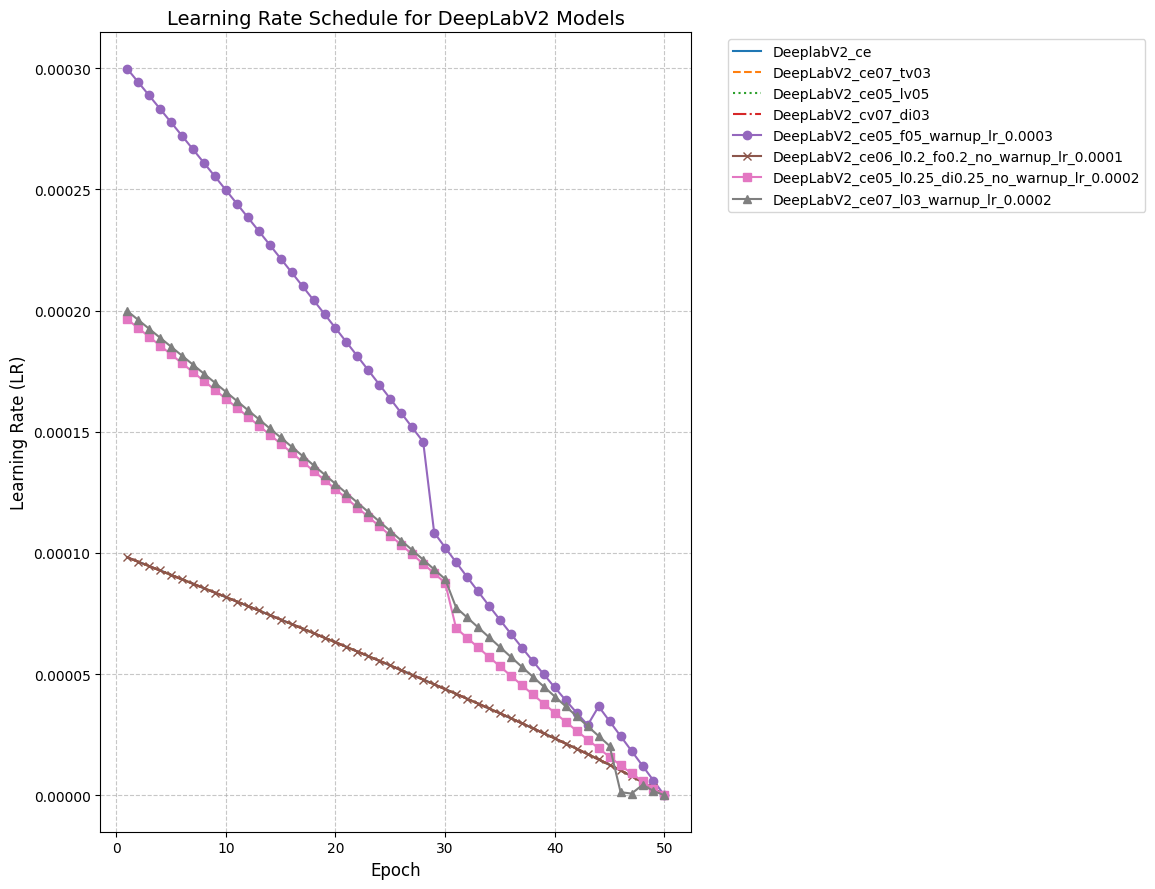

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# List of your CSV file names
file_names = [
    "DeeplabV2_ce.csv",
    "DeepLabV2_ce07_tv03.csv",
    "DeepLabV2_ce05_lv05.csv",
    "DeepLabV2_cv07_di03.csv",
    "DeepLabV2_ce05_f05_warnup_lr_0.0003.csv",
    "DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001.csv",
    "DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002.csv",
    "DeepLabV2_ce07_l03_warnup_lr_0.0002.csv"
]

# Define a list of different line styles and markers to cycle through
# Matplotlib automaticamente cicla i colori, quindi ci concentreremo su stili di linea e marcatori.
line_styles = ['-', '--', ':', '-.',  # Stili di linea standard
               'o-', 'x-', 's-', '^-'] # Stili di linea con marcatori (punto, croce, quadrato, triangolo)

plt.figure(figsize=(14, 9)) # Figura leggermente più grande per una migliore leggibilità

for i, file_name in enumerate(file_names):
    # Usa l'operatore modulo per ciclare attraverso la lista di stili
    current_style = line_styles[i % len(line_styles)]

    try:
        # Assicurati che i file CSV siano nella stessa directory dello script Python,
        # oppure specifica il percorso completo del file:
        # df = pd.read_csv(os.path.join("C:/Percorso/Alla/Tua/Cartella/", file_name))
        df = pd.read_csv(file_name)

        # Estrai le colonne 'epoch' e 'lr'
        if 'epoch' in df.columns and 'lr' in df.columns:
            epochs = df['epoch']
            lrs = df['lr']
            
            # Usa il nome del file (senza estensione) per la legenda
            label = os.path.splitext(file_name)[0]
            
            # Disegna la linea con lo stile/marcatore assegnato
            plt.plot(epochs, lrs, current_style, label=label, linewidth=1.5) # Aggiunto linewidth per chiarezza
        else:
            print(f"Saltando '{file_name}': Colonne 'epoch' o 'lr' mancanti.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione di '{file_name}': {e}")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate (LR)", fontsize=12)
plt.title("Learning Rate Schedule for DeepLabV2 Models", fontsize=14)
# Posiziona la legenda fuori dal grafico, adatta il layout per fare spazio
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7) # Migliorata la visibilità della griglia
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adatta il layout per fare spazio alla legenda sulla destra
plt.show()

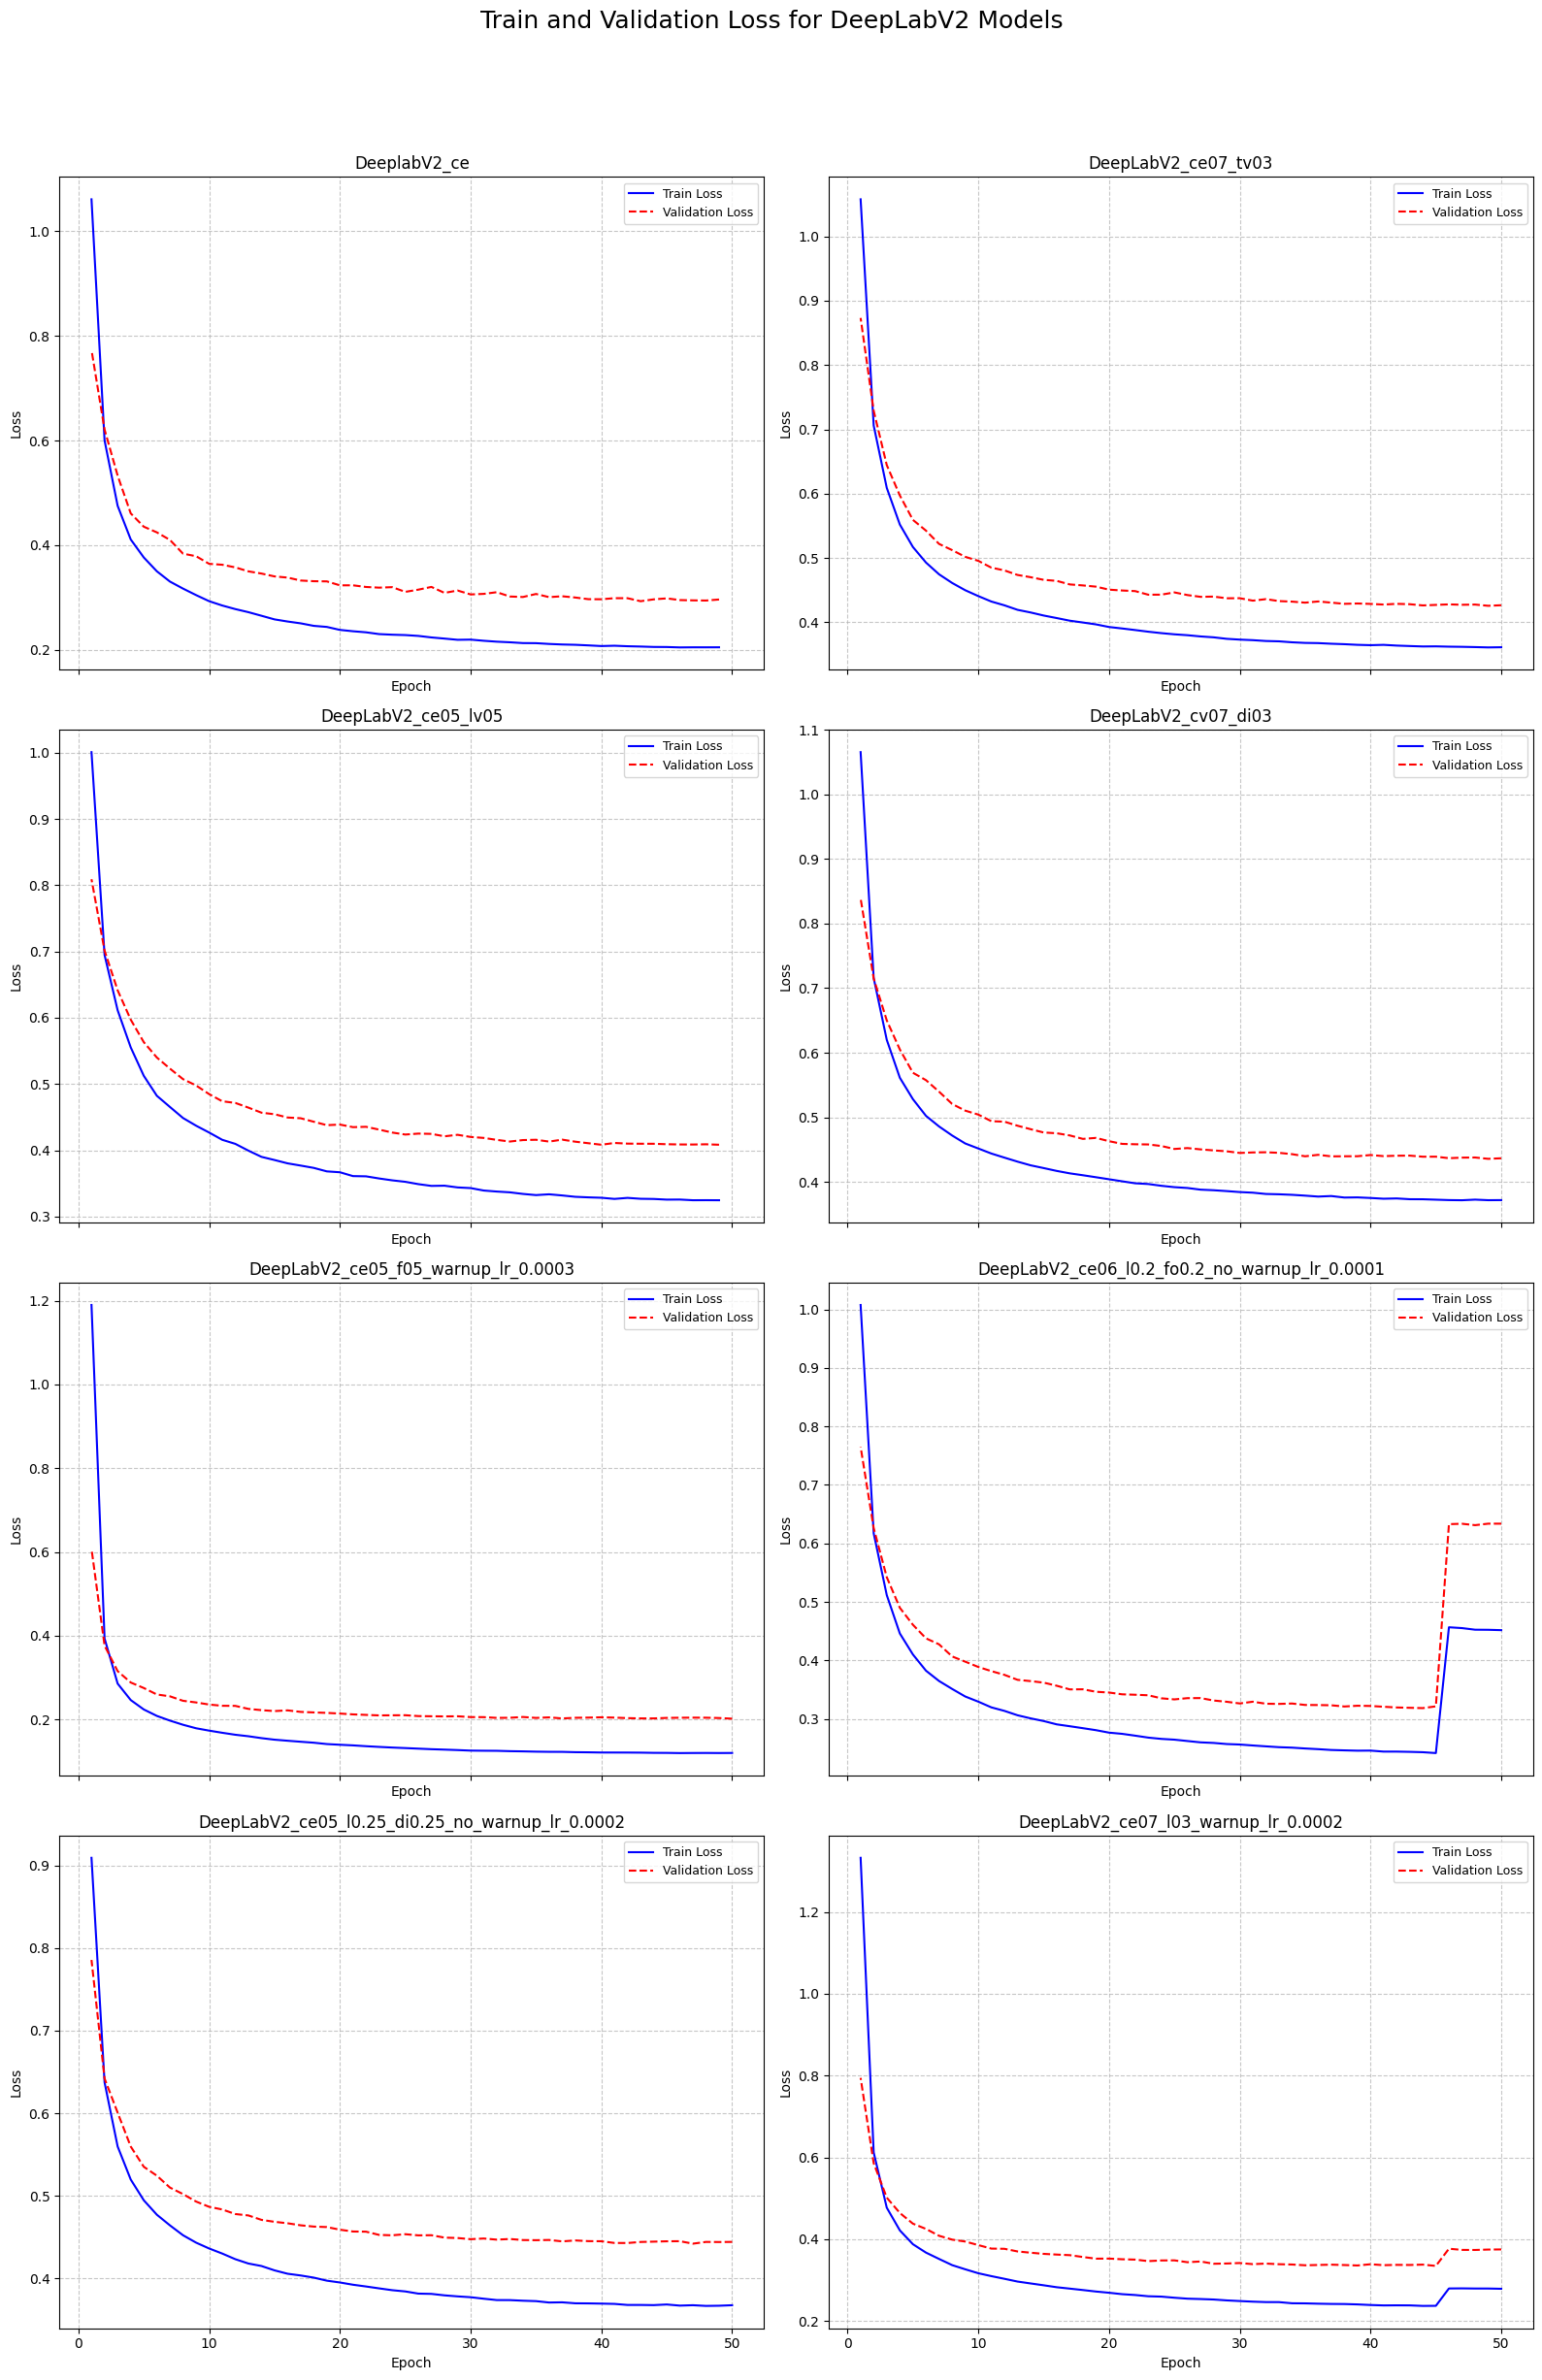

In [3]:
# Create a figure with a grid of subplots (e.g., 4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 24), sharex=True, sharey=False) # sharex=True per allineare gli assi x
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

fig.suptitle("Train and Validation Loss for DeepLabV2 Models", fontsize=18, y=1.02) # Main title for the figure

for i, file_name in enumerate(file_names):
    ax = axes[i] # Get the current subplot axis
    
    try:
        df = pd.read_csv(file_name)

        # Check for required columns
        required_cols = ['epoch', 'train_loss', 'val_loss']
        if all(col in df.columns for col in required_cols):
            epochs = df['epoch']
            train_loss = df['train_loss']
            val_loss = df['val_loss']
            
            # Use the base file name (without extension) for the subplot title
            model_name = os.path.splitext(file_name)[0]
            
            ax.plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=1.5)
            ax.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=1.5)
            
            ax.set_title(f"{model_name}", fontsize=12)
            ax.set_xlabel("Epoch", fontsize=10)
            ax.set_ylabel("Loss", fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            missing_cols = [col for col in required_cols if col not in df.columns]
            ax.set_title(f"Skipping {file_name}: Missing columns {missing_cols}", fontsize=10)
            ax.text(0.5, 0.5, "Data N/A", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            print(f"Skipping '{file_name}': Missing columns: {missing_cols}")
            
    except FileNotFoundError:
        ax.set_title(f"File Not Found: {file_name}", fontsize=10)
        ax.text(0.5, 0.5, "File Missing", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"Error: File '{file_name}' not found. Please ensure it's in the correct directory.")
    except Exception as e:
        ax.set_title(f"Error for {file_name}", fontsize=10)
        ax.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"An error occurred while processing '{file_name}': {e}")

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent main title overlap
plt.show()

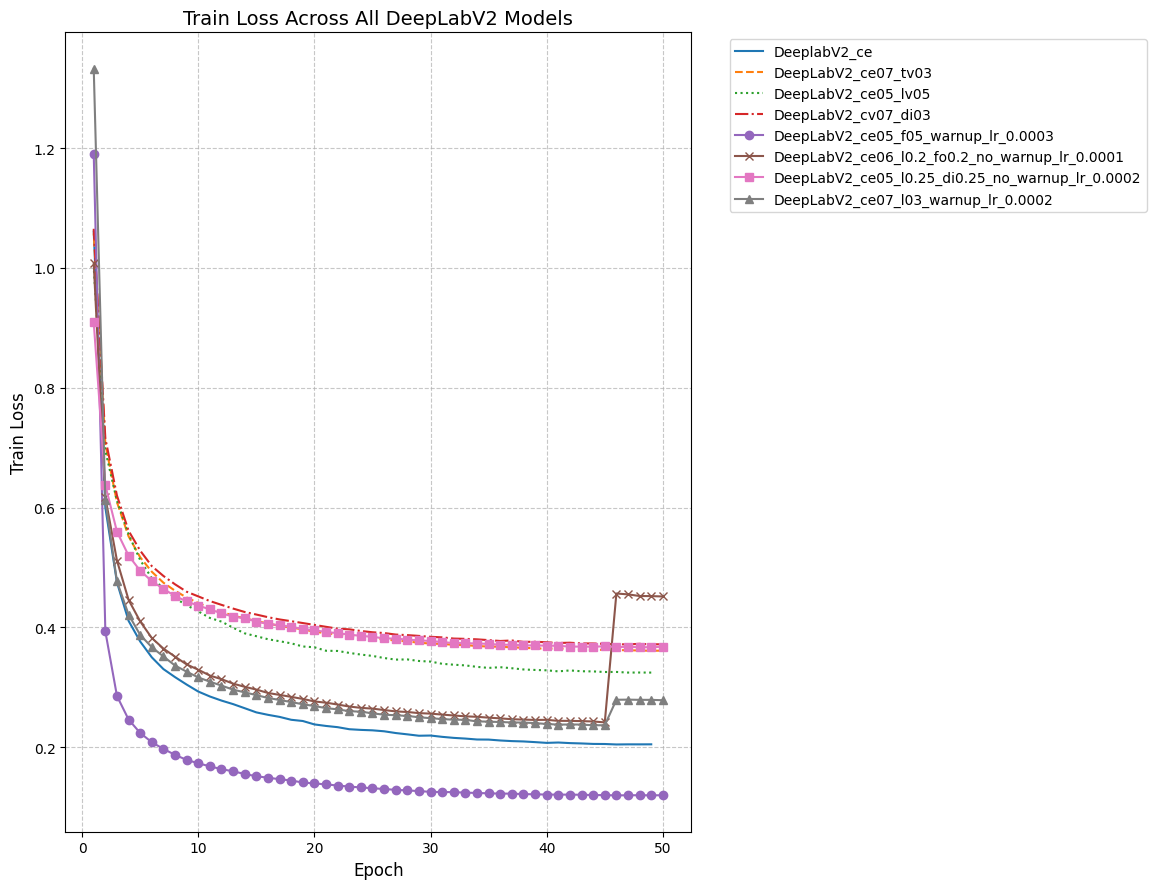

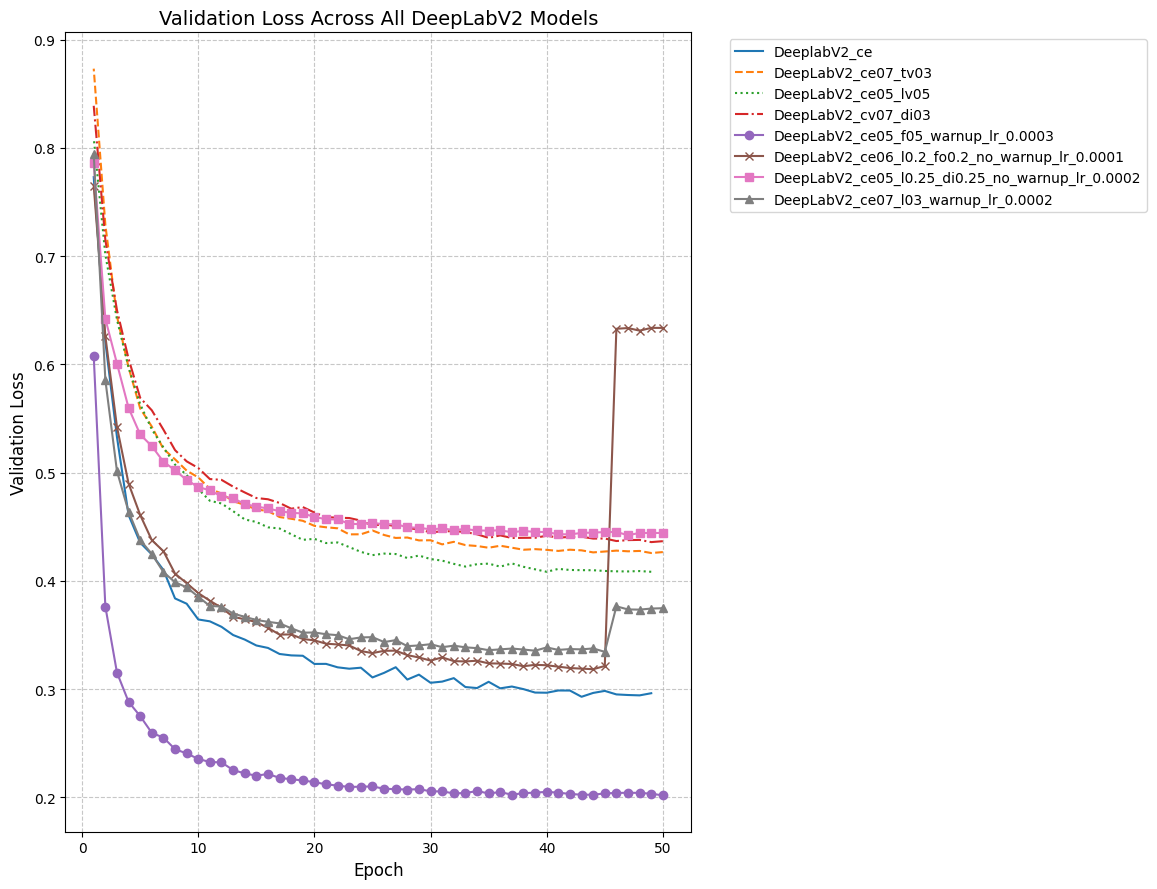

In [4]:
# Define a list of different line styles and markers to cycle through
line_styles = ['-', '--', ':', '-.',  # Standard line styles
               'o-', 'x-', 's-', '^-'] # Line styles with markers (circle, x, square, triangle_up)

# --- Plot for all Train Losses ---
plt.figure(figsize=(14, 9))
plt.title("Train Loss Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Train Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)]
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'train_loss' in df.columns:
            epochs = df['epoch']
            train_loss = df['train_loss']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, train_loss, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping train loss for '{file_name}': Missing 'epoch' or 'train_loss' column.")
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for train loss plot. Please ensure it's in the correct directory.")
    except Exception as e:
        print(f"An error occurred while processing train loss for '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

# --- Plot for all Validation Losses ---
plt.figure(figsize=(14, 9))
plt.title("Validation Loss Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)] # Use the same cycle of styles
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'val_loss' in df.columns:
            epochs = df['epoch']
            val_loss = df['val_loss']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, val_loss, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping validation loss for '{file_name}': Missing 'epoch' or 'val_loss' column.")
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for validation loss plot. Please ensure it's in the correct directory.")
    except Exception as e:
        print(f"An error occurred while processing validation loss for '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

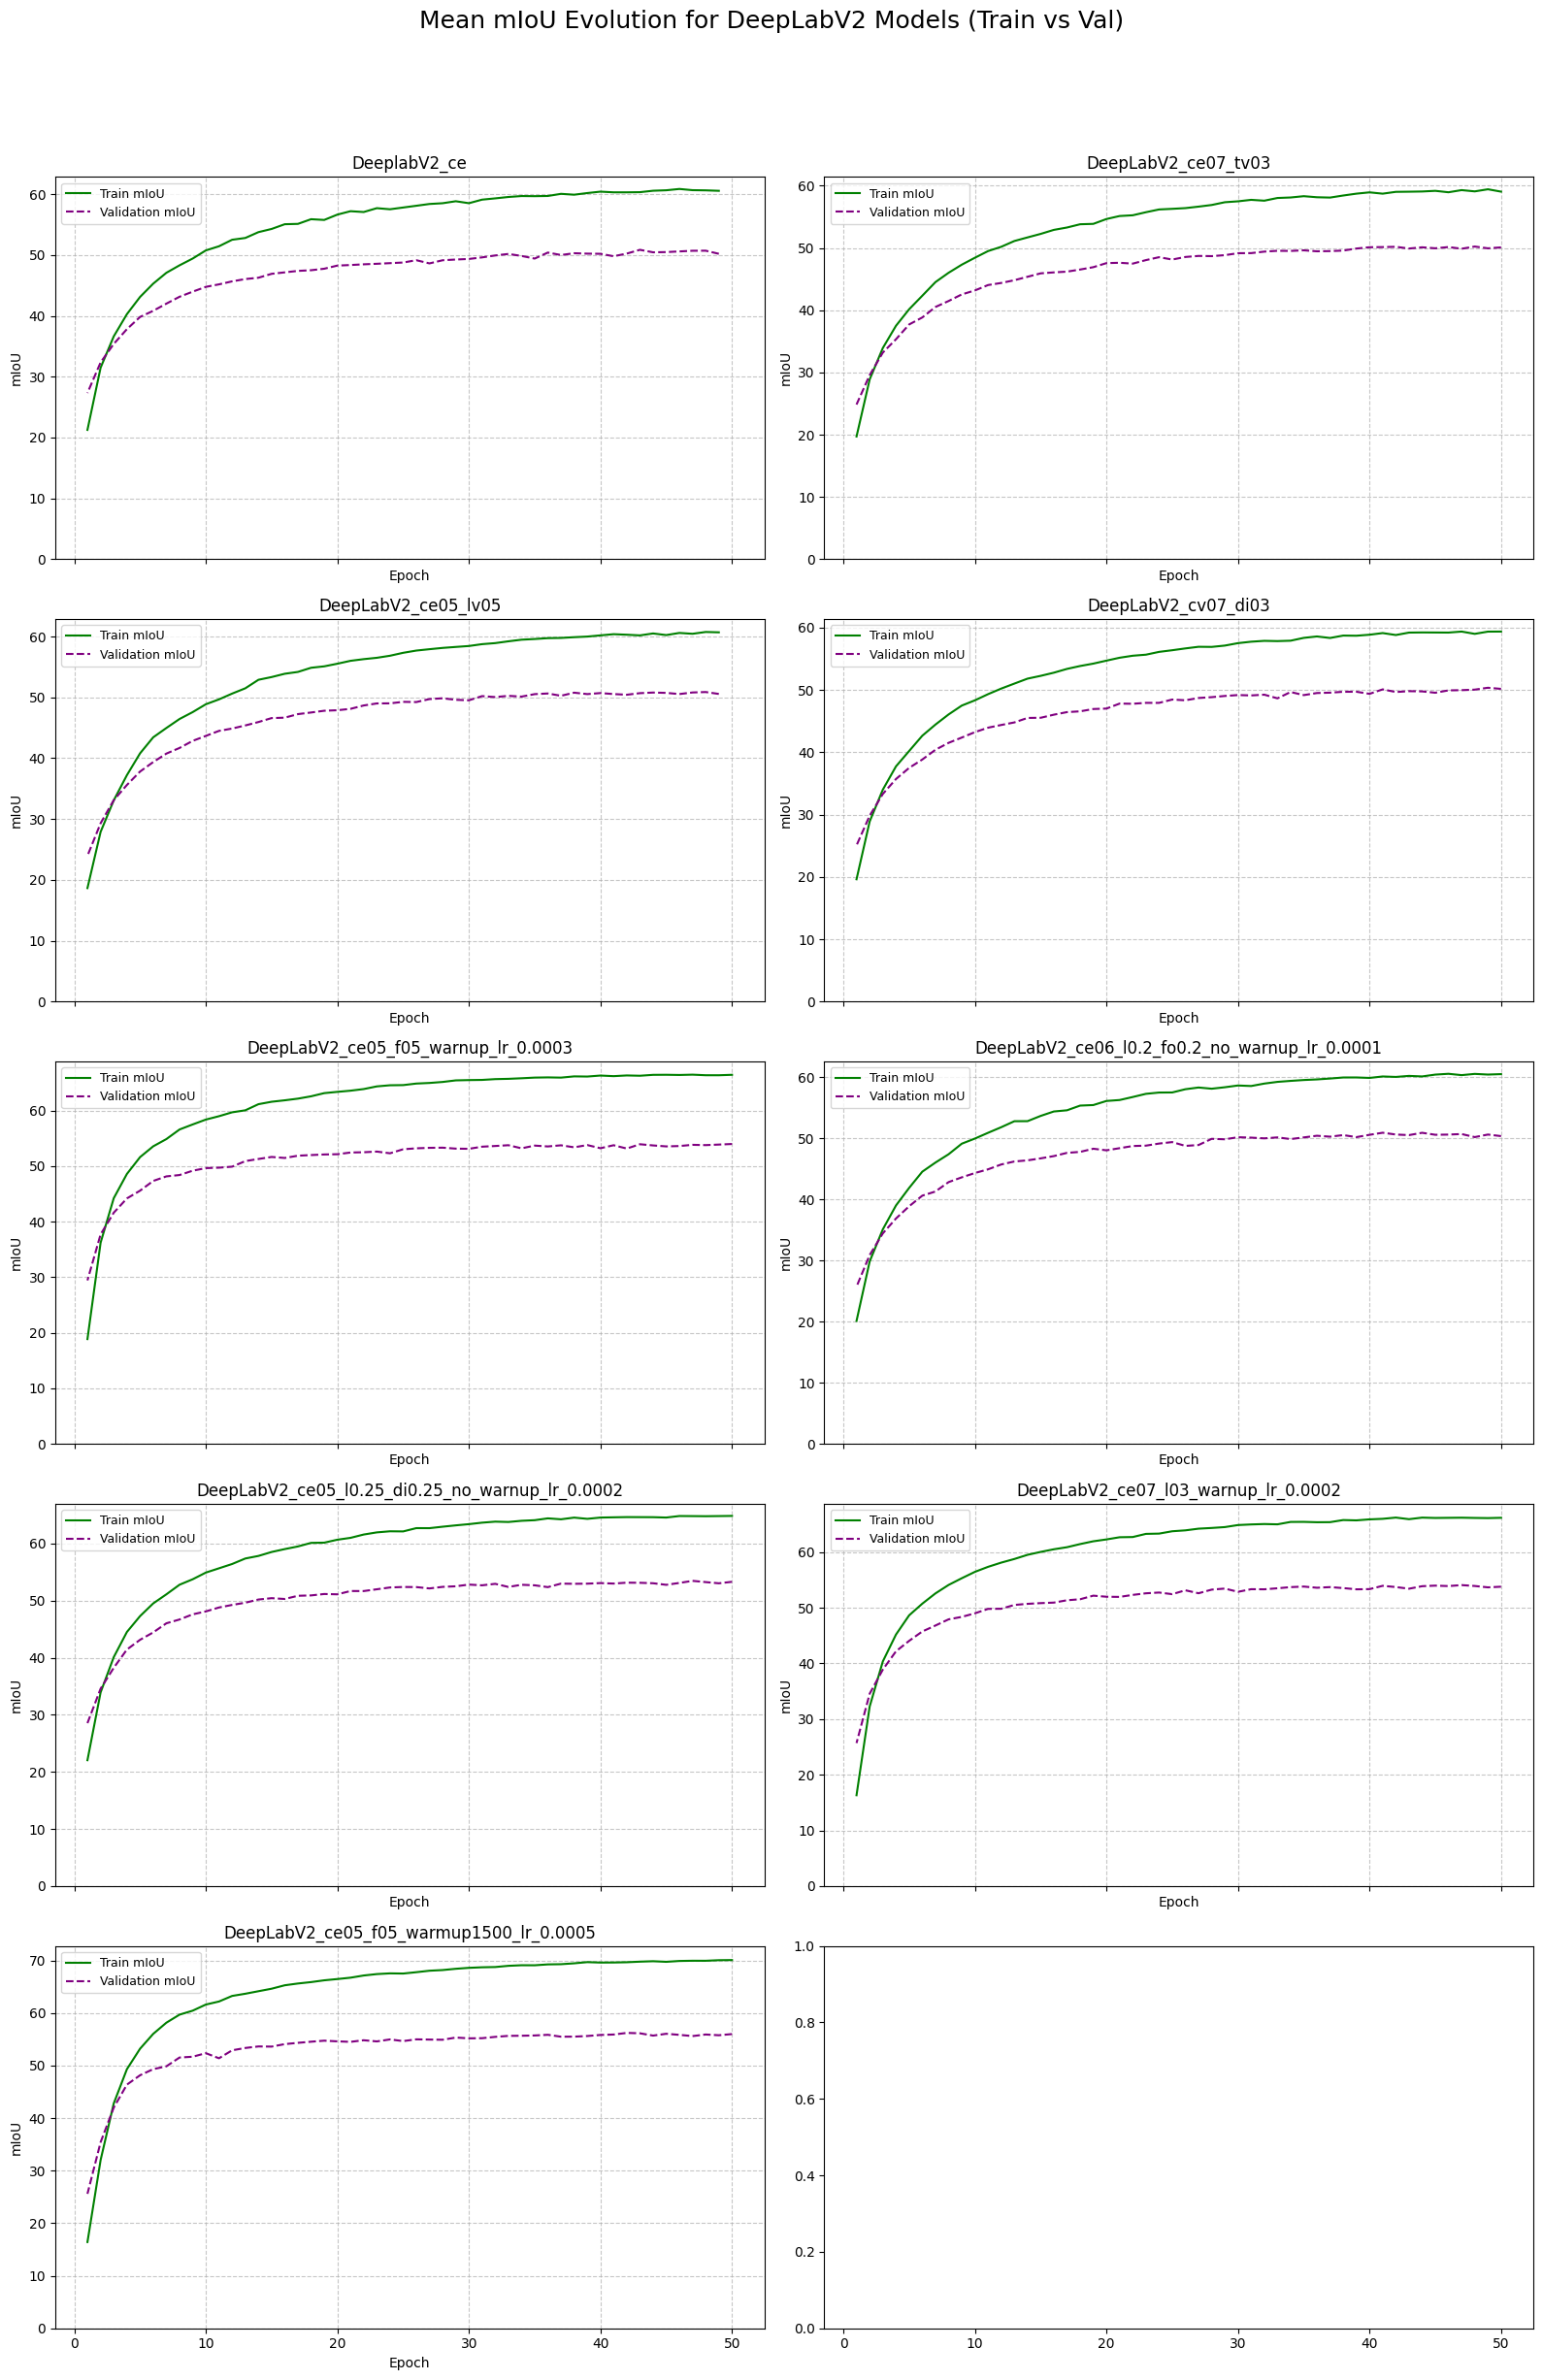


--- Final mIoU Table ---
                                          Model Final Train mIoU Final Val mIoU Val mIoU (Class_0) Val mIoU (Class_1) Val mIoU (Class_2) Val mIoU (Class_3) Val mIoU (Class_4) Val mIoU (Class_5) Val mIoU (Class_6) Val mIoU (Class_7) Val mIoU (Class_8) Val mIoU (Class_9) Val mIoU (Class_10) Val mIoU (Class_11) Val mIoU (Class_12) Val mIoU (Class_13) Val mIoU (Class_14) Val mIoU (Class_15) Val mIoU (Class_16) Val mIoU (Class_17) Val mIoU (Class_18)
                                   DeeplabV2_ce              nan            nan                nan                nan                nan                nan                nan                nan                nan                nan                nan                nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan                 nan
                            DeepLabV2_ce07_tv03          19.7200        24

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast # To parse string representations of lists/arrays

file_names = [
    "DeeplabV2_ce.csv",
    "DeepLabV2_ce07_tv03.csv",
    "DeepLabV2_ce05_lv05.csv",
    "DeepLabV2_cv07_di03.csv",
    "DeepLabV2_ce05_f05_warnup_lr_0.0003.csv",
    "DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001.csv",
    "DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002.csv",
    "DeepLabV2_ce07_l03_warnup_lr_0.0002.csv",
    "DeepLabV2_ce05_f05_warmup1500_lr_0.0005.csv"
]

# Define number of classes based on the header provided earlier (class_0 to class_18)
NUM_CLASSES = 19 
class_val_cols = [f'class_{c}_val' for c in range(NUM_CLASSES)]
class_train_cols = [f'class_{c}_train' for c in range(NUM_CLASSES)]


# --- Part 1: Plots of mIoU evolution ---
fig, axes = plt.subplots(5, 2, figsize=(16, 24), sharex=True, sharey=False)
axes = axes.flatten()

fig.suptitle("Mean mIoU Evolution for DeepLabV2 Models (Train vs Val)", fontsize=18, y=1.02)

for i, file_name in enumerate(file_names):
    ax = axes[i]
    
    try:
        df = pd.read_csv(file_name)

        required_cols = ['epoch', 'train_mIoU', 'val_mIoU']
        if all(col in df.columns for col in required_cols):
            epochs = df['epoch']
            train_mIoU = df['train_mIoU']
            val_mIoU = df['val_mIoU']
            
            model_name = os.path.splitext(file_name)[0]
            
            ax.plot(epochs, train_mIoU, label='Train mIoU', color='green', linewidth=1.5)
            ax.plot(epochs, val_mIoU, label='Validation mIoU', color='purple', linestyle='--', linewidth=1.5)
            
            ax.set_title(f"{model_name}", fontsize=12)
            ax.set_xlabel("Epoch", fontsize=10)
            ax.set_ylabel("mIoU", fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_ylim(bottom=0) # Ensure mIoU starts from 0 or close to it
        else:
            missing_cols = [col for col in required_cols if col not in df.columns]
            ax.set_title(f"Skipping {file_name}: Missing columns {missing_cols}", fontsize=10)
            ax.text(0.5, 0.5, "Data N/A", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            print(f"Skipping mIoU plot for '{file_name}': Missing columns: {missing_cols}")
            
    except FileNotFoundError:
        ax.set_title(f"File Not Found: {file_name}", fontsize=10)
        ax.text(0.5, 0.5, "File Missing", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"Error: File '{file_name}' not found for mIoU plot.")
    except Exception as e:
        ax.set_title(f"Error for {file_name}", fontsize=10)
        ax.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        print(f"An error occurred while processing mIoU plot for '{file_name}': {e}")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# --- Part 2: Final mIoU Table ---
final_miou_data = []

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]
    try:
        df = pd.read_csv(file_name)
        # Get the last row (assuming last epoch is the last row)
        last_row = df.iloc[-1]

        # Extract mean mIoU
        final_train_mIoU = last_row.get('train_mIoU_final', last_row.get('train_mIoU', 'N/A')) # Check for _final or regular
        final_val_mIoU = last_row.get('val_mIoU_final', last_row.get('val_mIoU', 'N/A')) # Check for _final or regular

        # Extract per-class mIoU for validation
        per_class_val_miou = {}
        missing_per_class_cols = False
        for c_col in class_val_cols:
            if c_col in last_row:
                per_class_val_miou[f'Class_{c_col.split("_")[1]}'] = last_row[c_col]
            else:
                missing_per_class_cols = True
                break # Stop if a class column is missing

        row_data = {
            'Model': model_name,
            'Final Train mIoU': f'{final_train_mIoU:.4f}' if isinstance(final_train_mIoU, (int, float)) else final_train_mIoU,
            'Final Val mIoU': f'{final_val_mIoU:.4f}' if isinstance(final_val_mIoU, (int, float)) else final_val_mIoU,
        }
        
        if not missing_per_class_cols:
            # Add per-class mIoUs to the row data, formatted for display
            for class_name, val in per_class_val_miou.items():
                row_data[f'Val mIoU ({class_name})'] = f'{val:.4f}' if isinstance(val, (int, float)) else val
        else:
            print(f"Warning: Per-class validation mIoU columns not found for '{file_name}'. Table will not include them for this model.")
            # Add placeholders or omit columns if missing
            for c_col in class_val_cols:
                 row_data[f'Val mIoU (Class_{c_col.split("_")[1]})'] = 'N/A'


        final_miou_data.append(row_data)

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found for mIoU table. Skipping.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}' for mIoU table: {e}")

if final_miou_data:
    df_final_miou = pd.DataFrame(final_miou_data)
    # Display the table
    print("\n--- Final mIoU Table ---")
    print(df_final_miou.to_string(index=False))
else:
    print("\nNo data processed for the final mIoU table.")

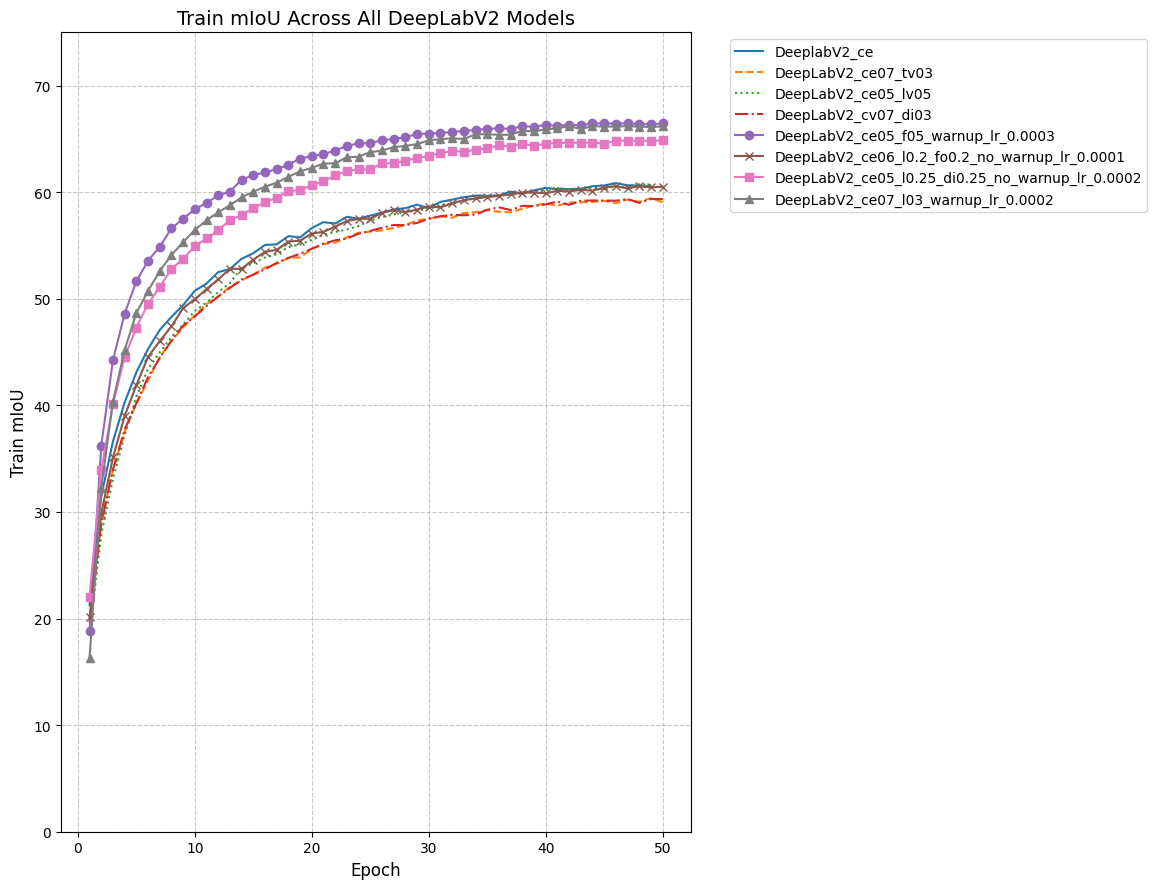

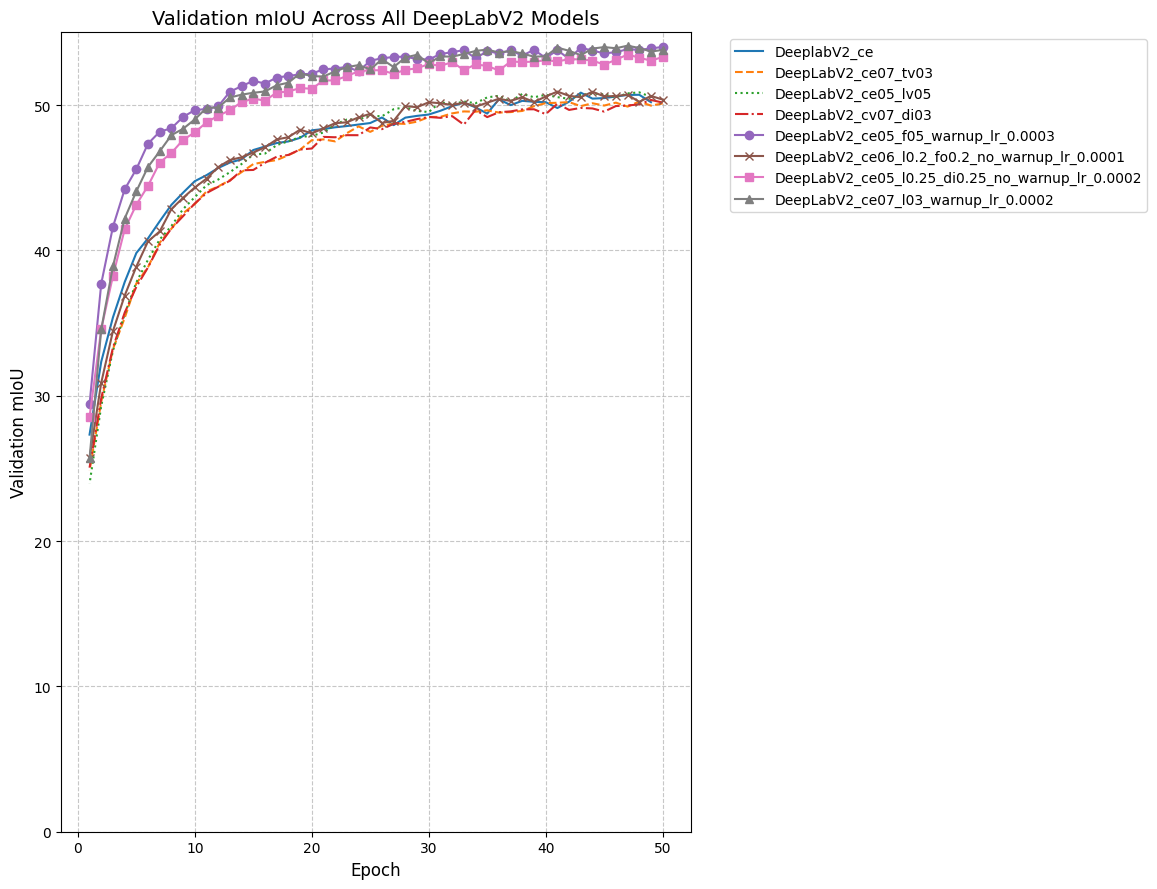

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define a list of different line styles and markers to cycle through
# Matplotlib automatically cycles colors, so we'll focus on line styles and markers.
line_styles = ['-', '--', ':', '-.',  # Standard line styles
               'o-', 'x-', 's-', '^-'] # Line styles with markers (circle, x, square, triangle_up)


# --- Plot for all Train mIoU Curves ---
plt.figure(figsize=(14, 9))
plt.title("Train mIoU Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Train mIoU", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 75) # <--- MODIFICA QUI: impostato l'asse Y da 0 a 55


for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)]
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'train_mIoU' in df.columns:
            epochs = df['epoch']
            train_mIoU = df['train_mIoU']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, train_mIoU, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping train mIoU for '{file_name}': Missing 'epoch' or 'train_mIoU' column.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato per il plot della train mIoU. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione della train mIoU per '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()


# --- Plot for all Validation mIoU Curves ---
plt.figure(figsize=(14, 9))
plt.title("Validation mIoU Across All DeepLabV2 Models", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation mIoU", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 55) # <--- MODIFICA QUI: impostato l'asse Y da 0 a 55


for i, file_name in enumerate(file_names):
    current_style = line_styles[i % len(line_styles)] # Use the same cycle of styles
    
    try:
        df = pd.read_csv(file_name)
        if 'epoch' in df.columns and 'val_mIoU' in df.columns:
            epochs = df['epoch']
            val_mIoU = df['val_mIoU']
            label = os.path.splitext(file_name)[0]
            plt.plot(epochs, val_mIoU, current_style, label=label, linewidth=1.5)
        else:
            print(f"Skipping validation mIoU for '{file_name}': Missing 'epoch' or 'val_mIoU' column.")
    except FileNotFoundError:
        print(f"Errore: File '{file_name}' non trovato per il plot della validation mIoU. Assicurati che sia nella directory corretta.")
    except Exception as e:
        print(f"Si è verificato un errore durante l'elaborazione della validation mIoU per '{file_name}': {e}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend on the right
plt.show()

C:\Users\elisa\AppData\Local\Temp\ipykernel_37552\3536993268.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', NUM_CLASSES)


Generating per-class mIoU plots for each model...


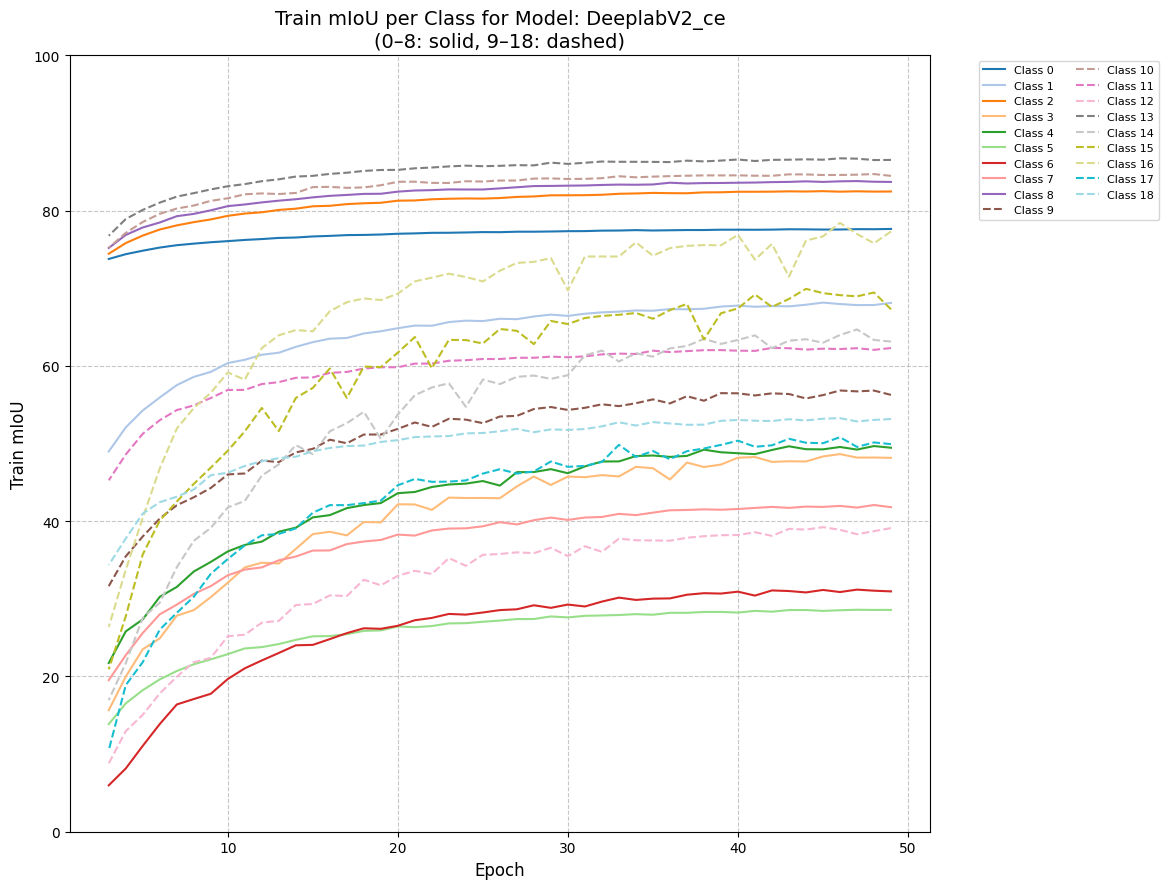

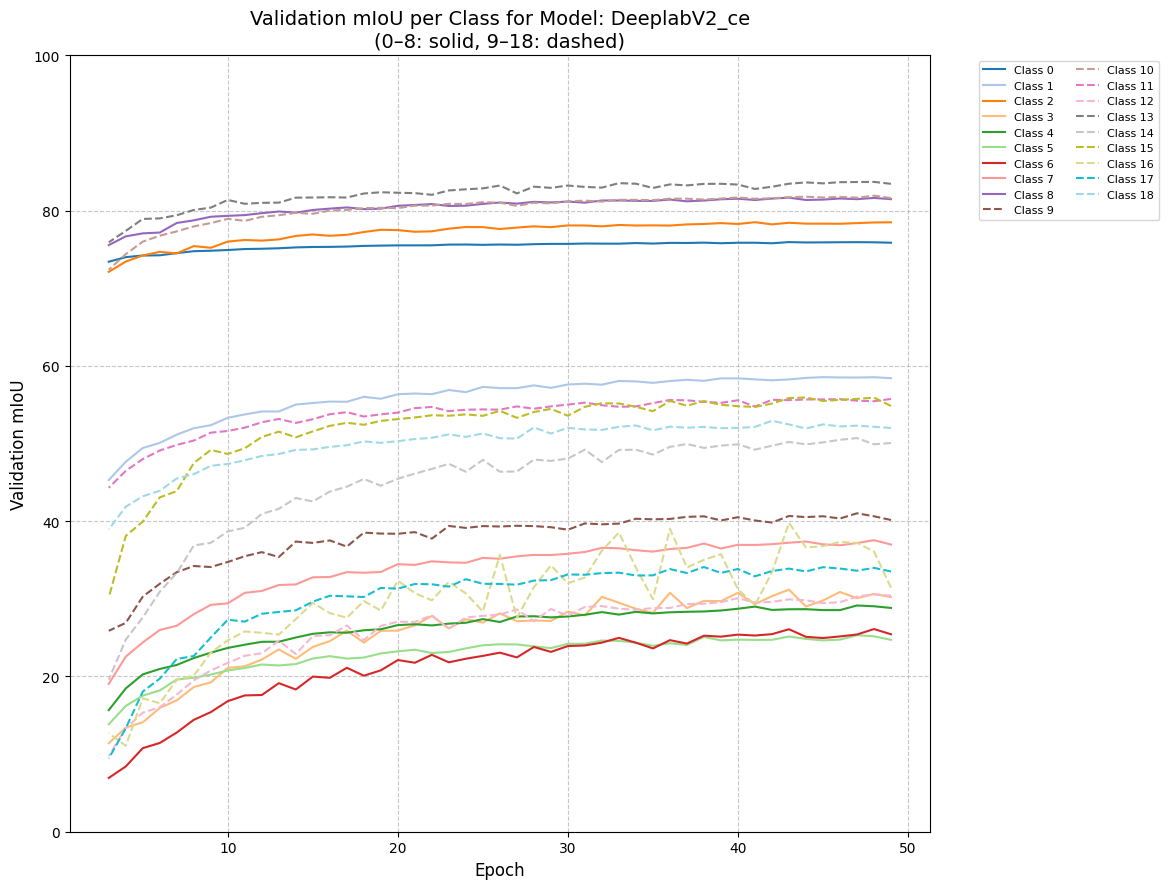

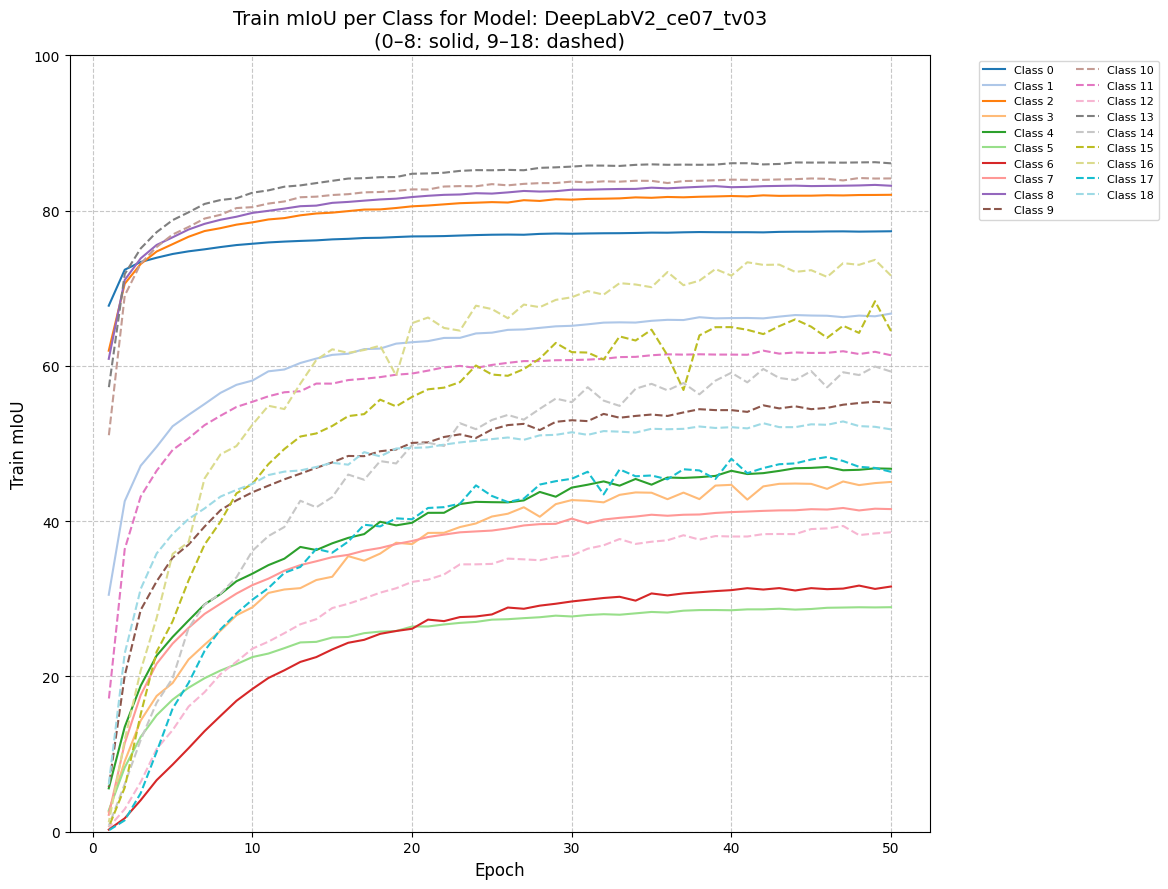

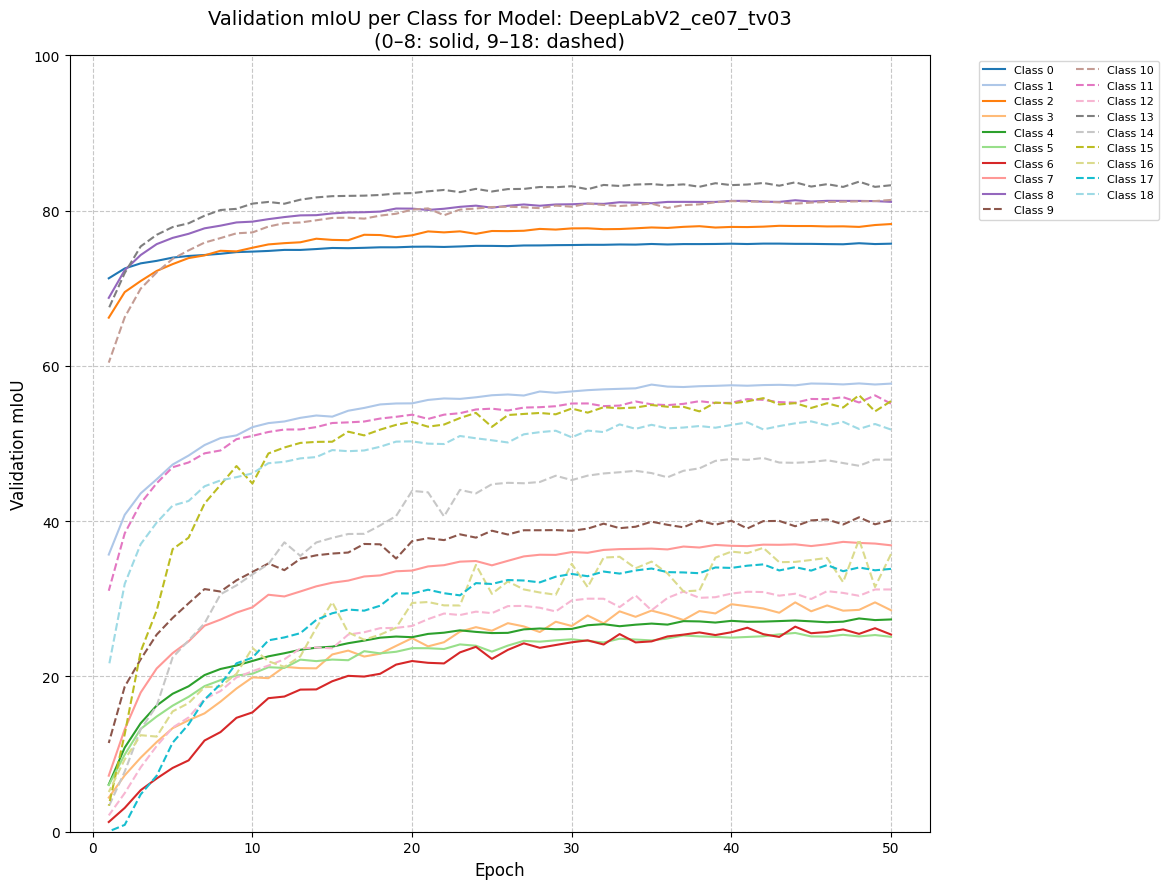

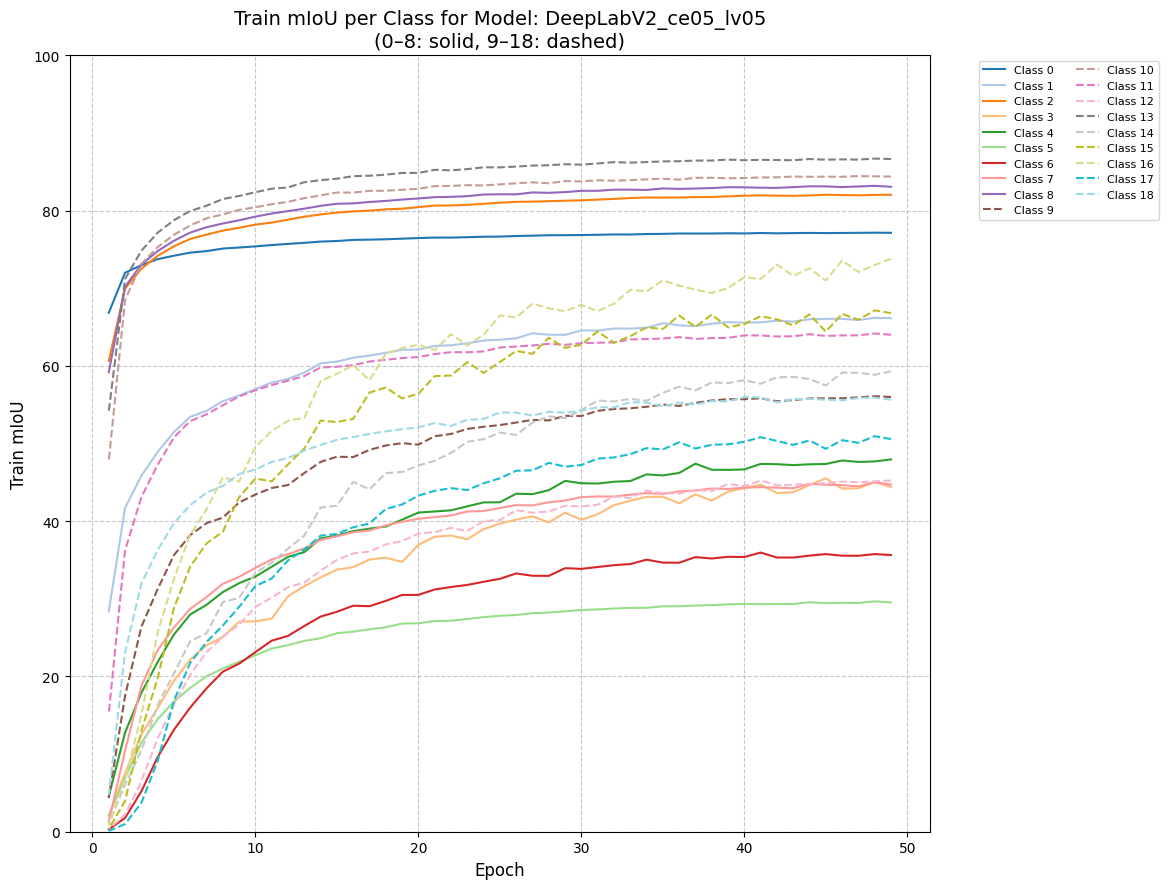

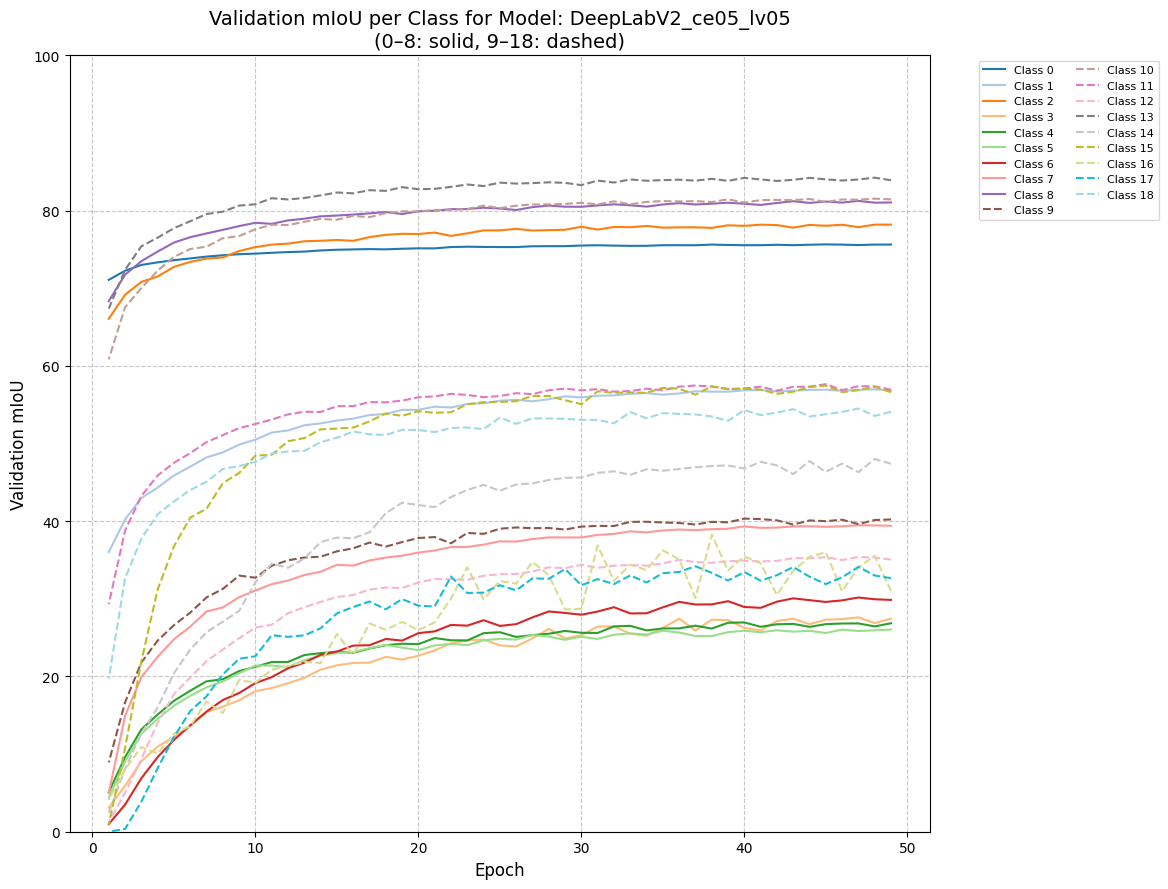

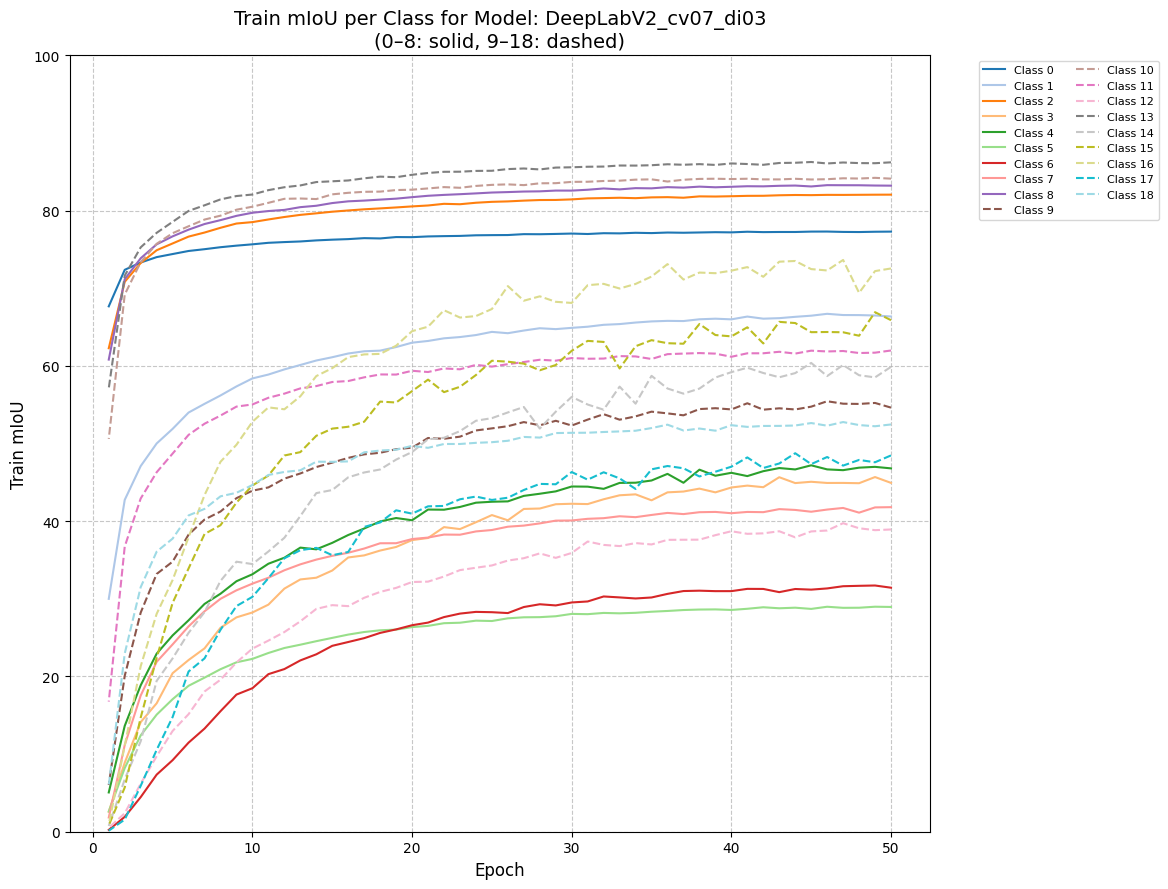

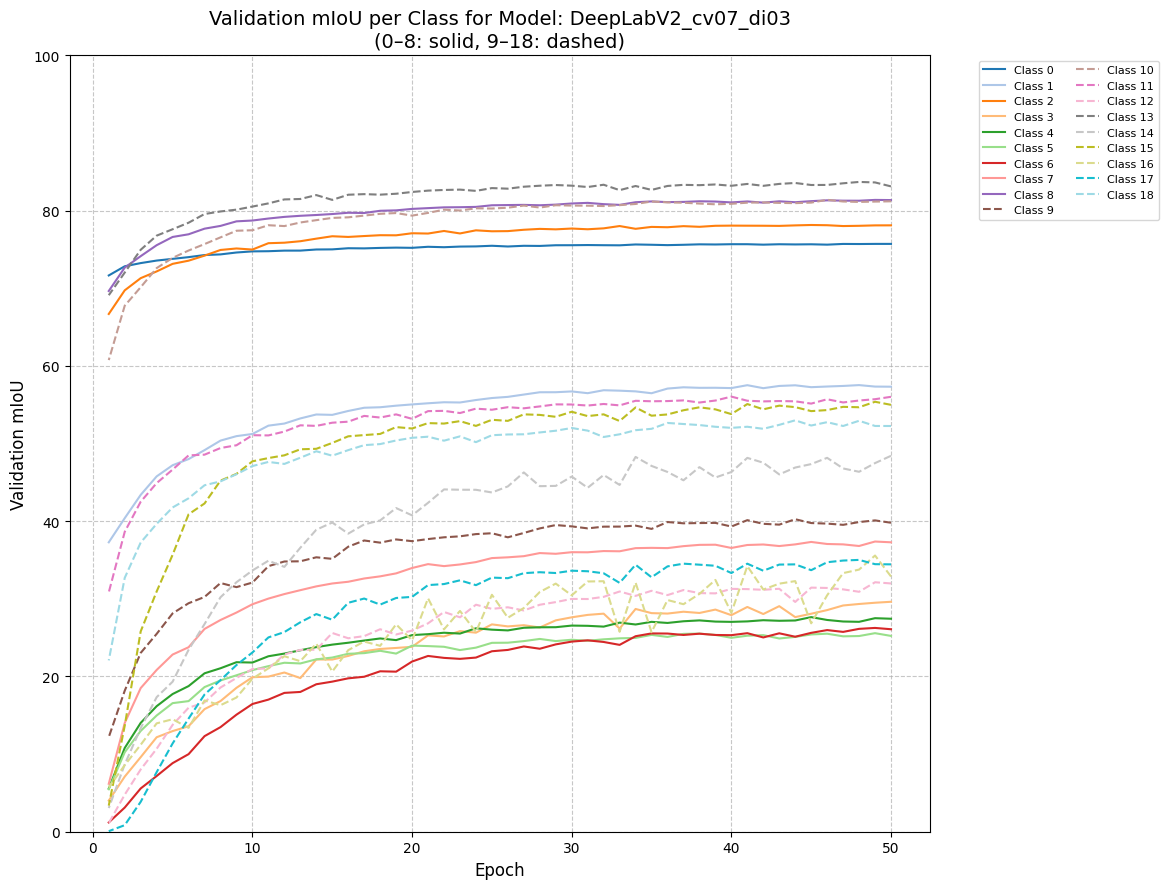

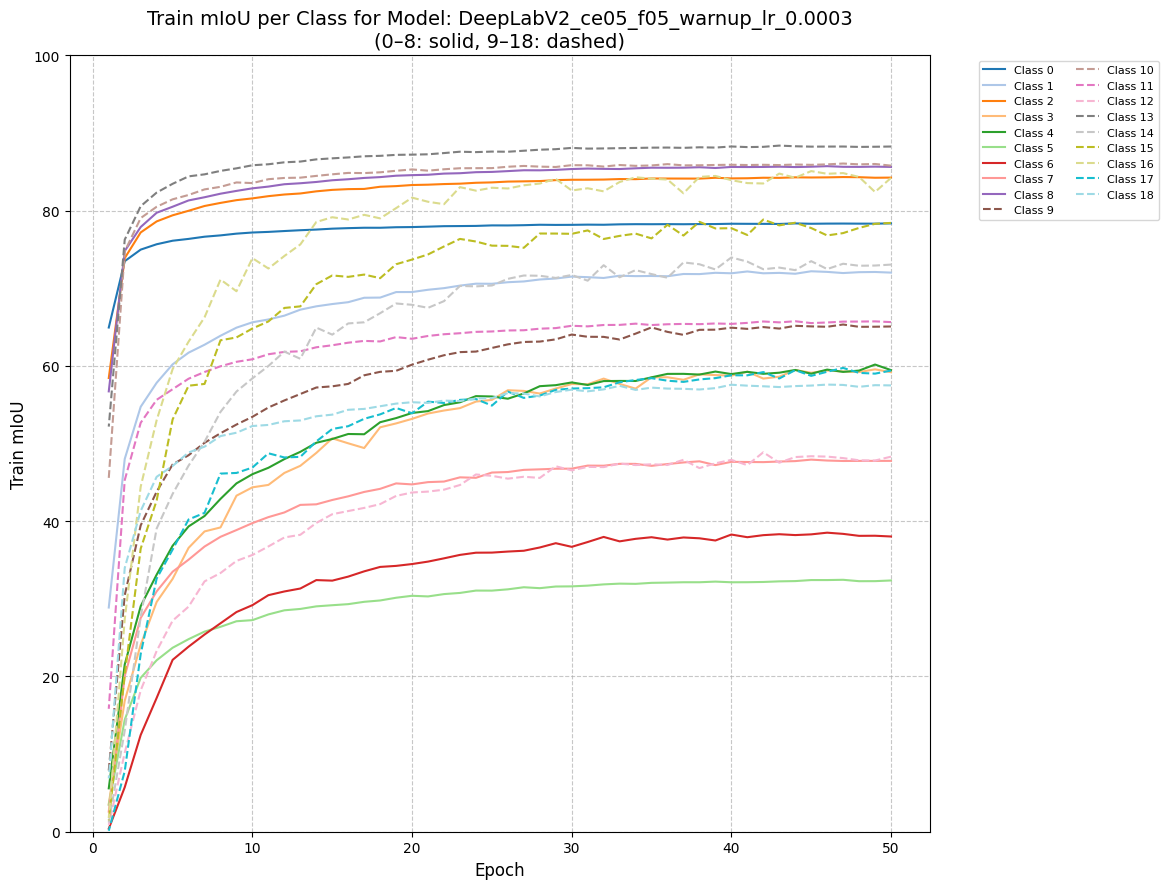

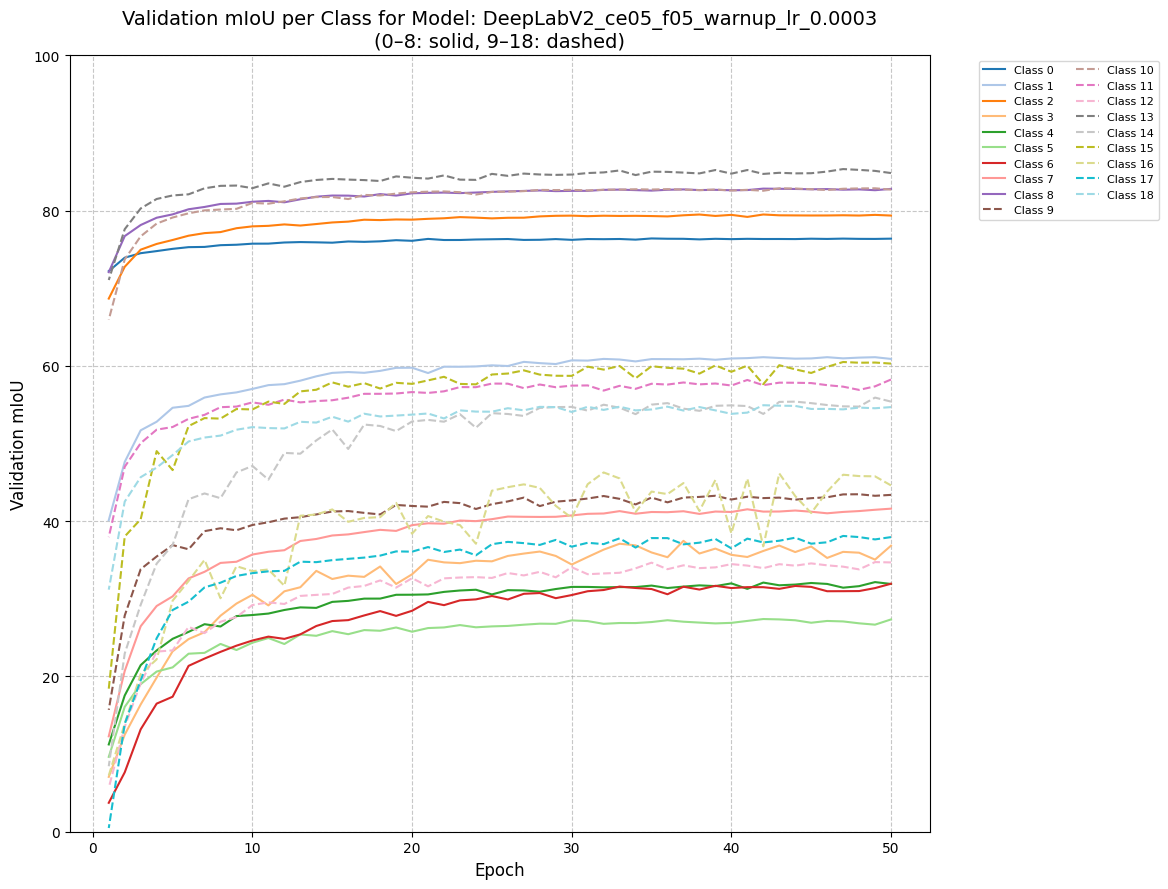

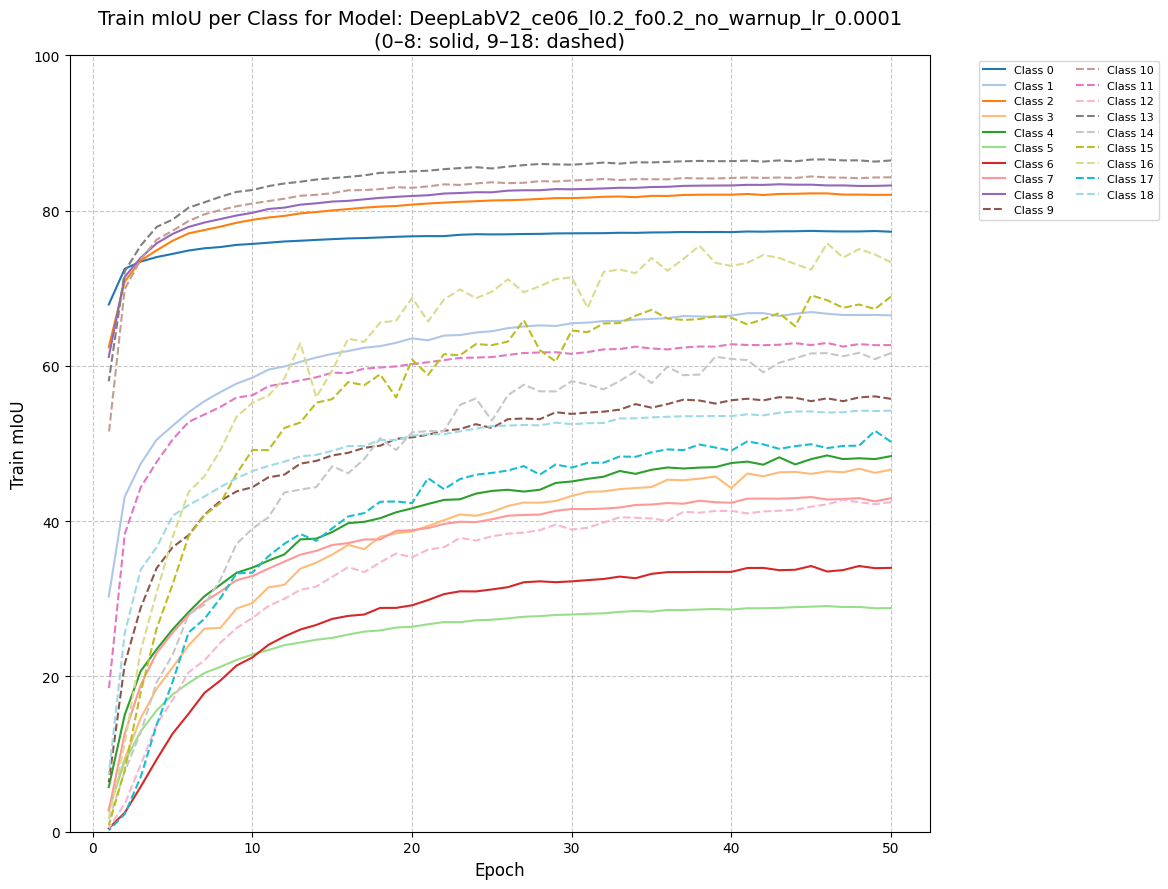

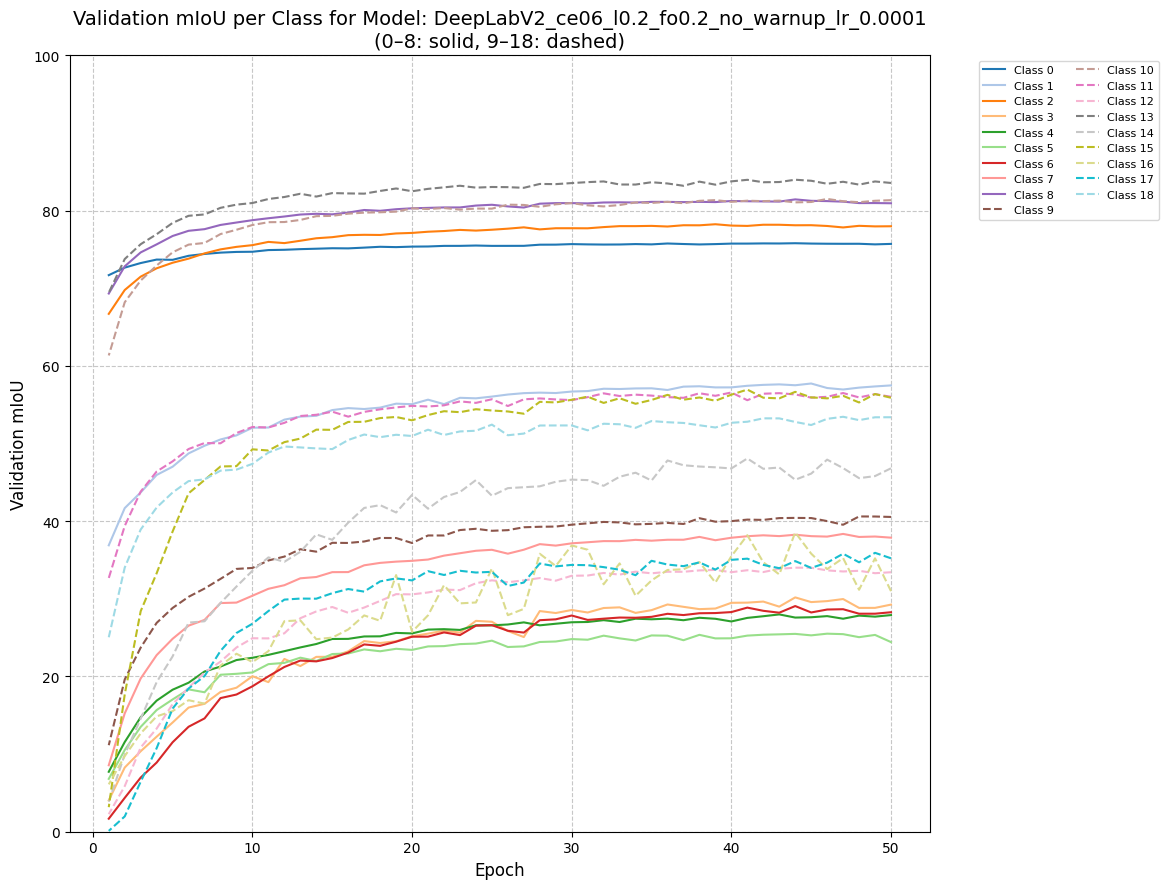

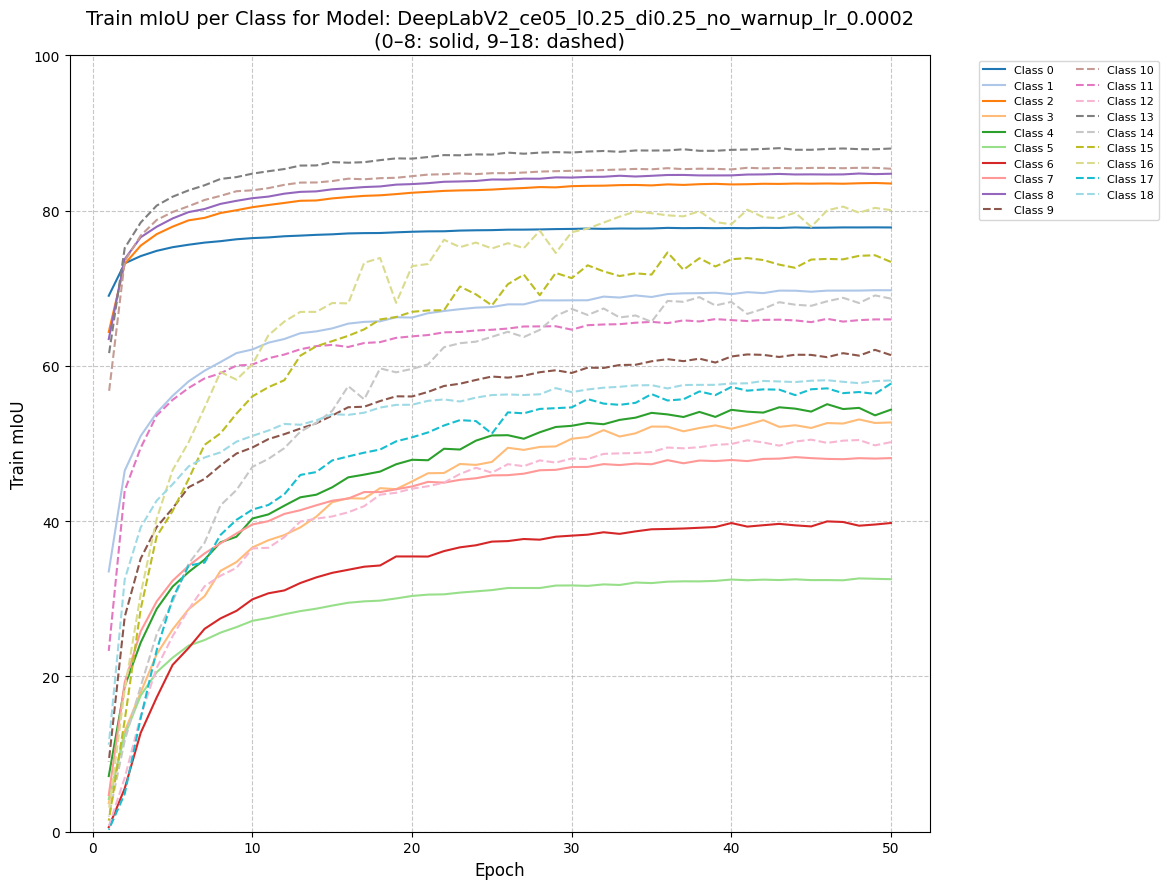

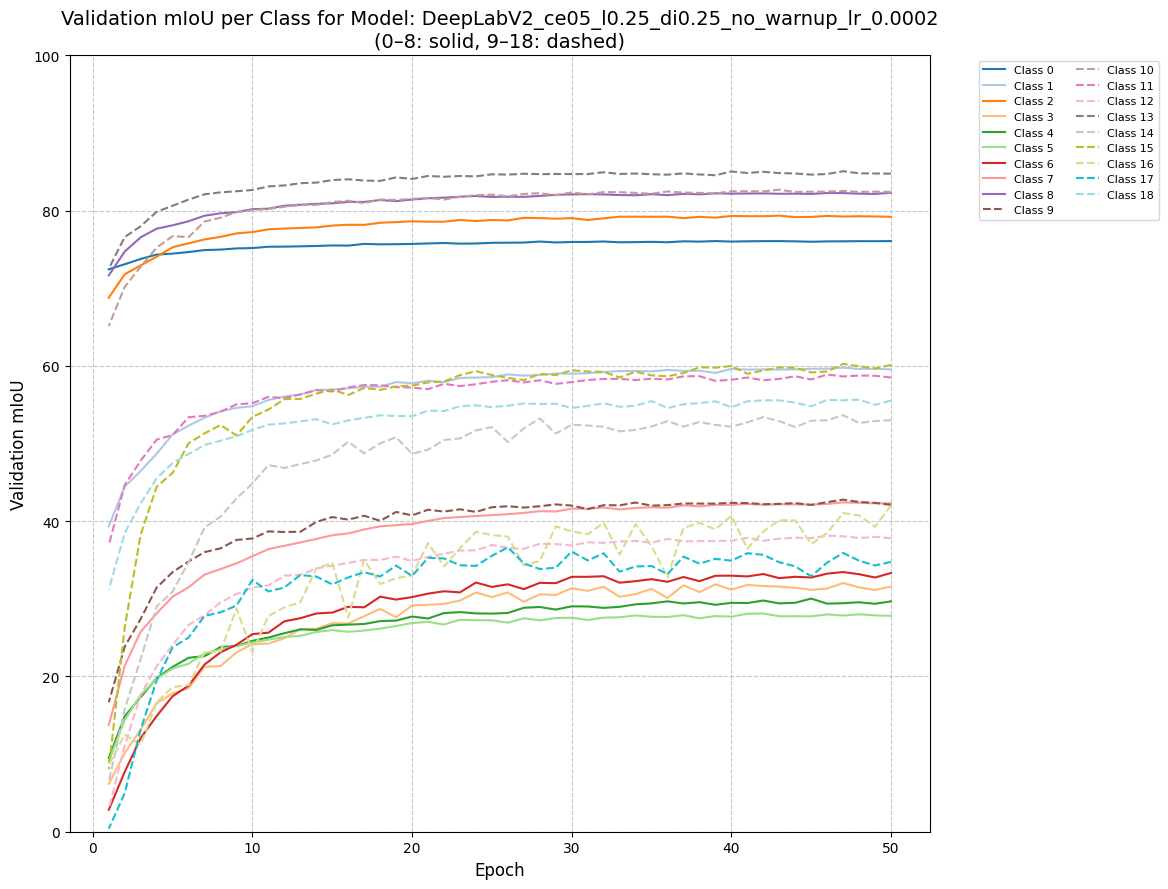

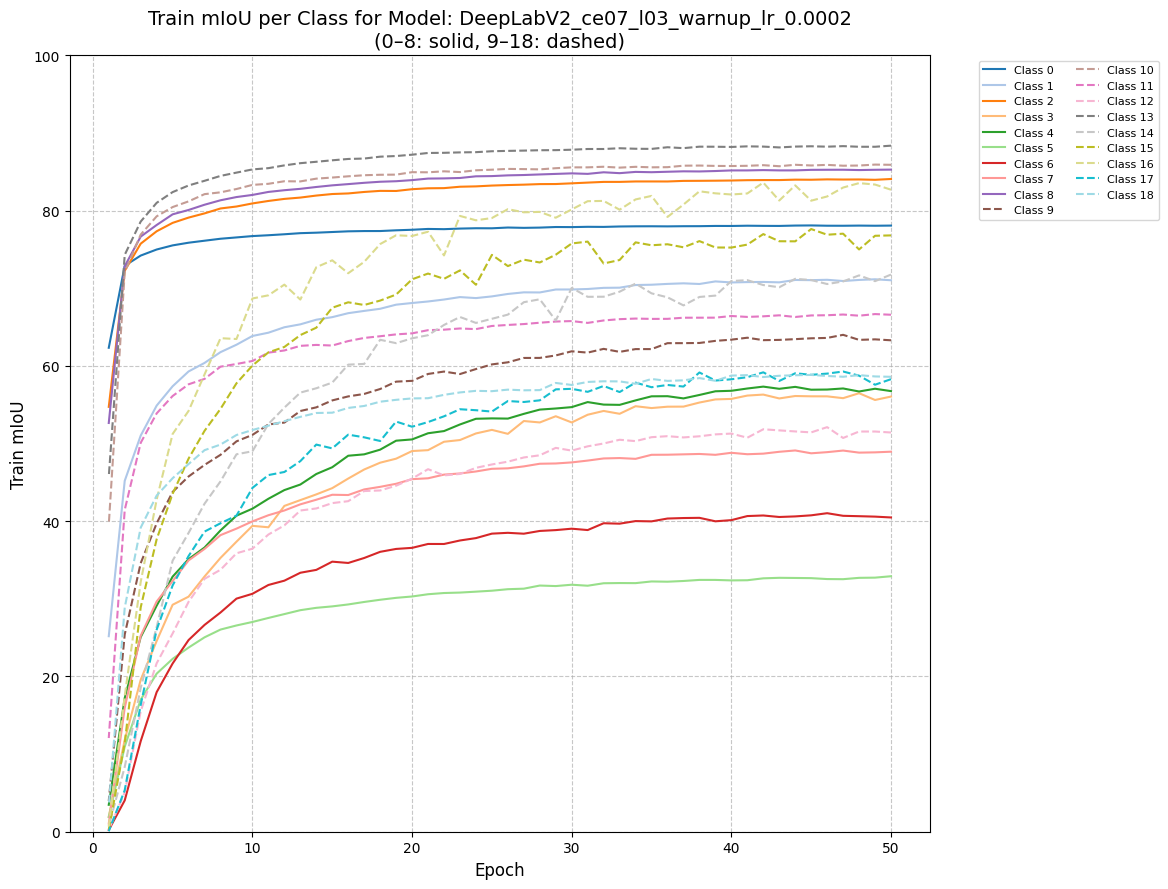

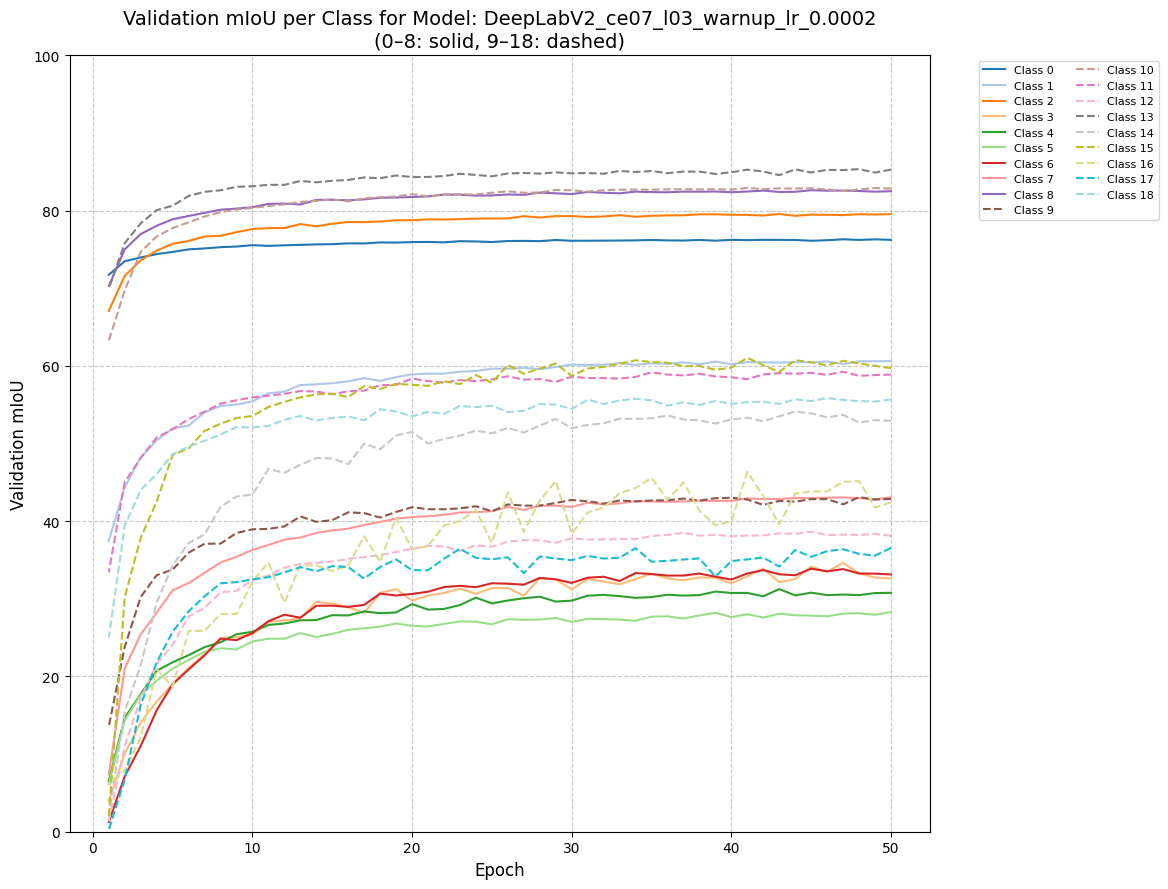

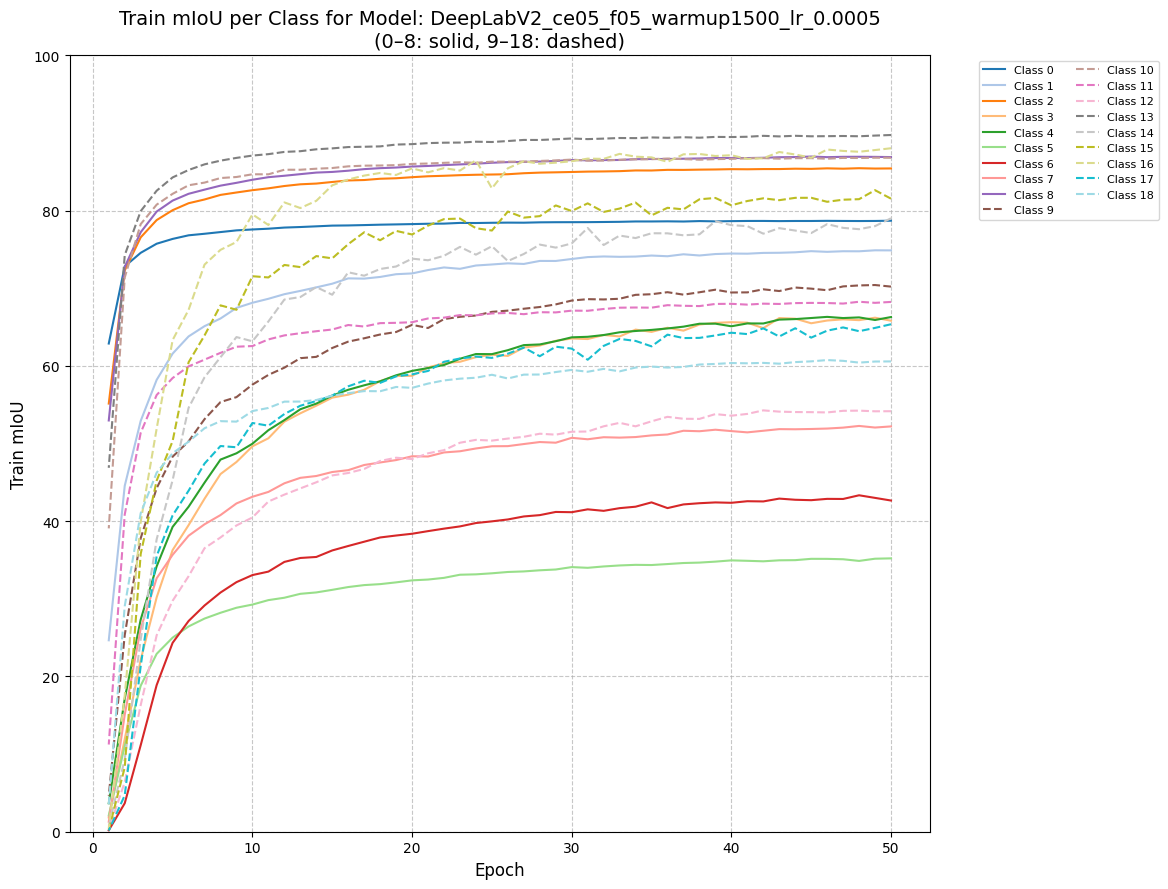

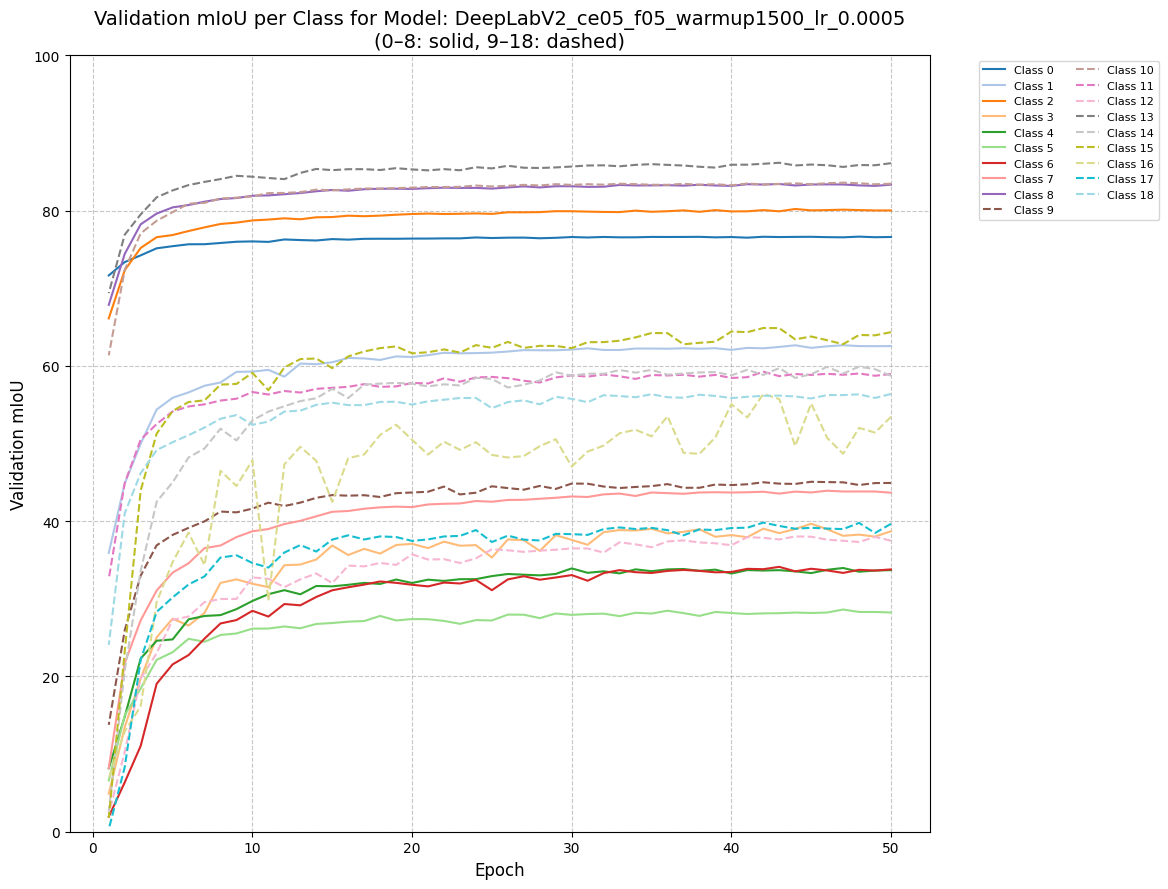


Finished generating per-class mIoU plots. Please ensure files are available if running locally.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

# Assuming 19 classes based on your CSV header (class_0 to class_18)
NUM_CLASSES = 19 
file_names = [
    "DeeplabV2_ce.csv",
    "DeepLabV2_ce07_tv03.csv",
    "DeepLabV2_ce05_lv05.csv",
    "DeepLabV2_cv07_di03.csv",
    "DeepLabV2_ce05_f05_warnup_lr_0.0003.csv",
    "DeepLabV2_ce06_l0.2_fo0.2_no_warnup_lr_0.0001.csv",
    "DeepLabV2_ce05_l0.25_di0.25_no_warnup_lr_0.0002.csv",
    "DeepLabV2_ce07_l03_warnup_lr_0.0002.csv",
    "DeepLabV2_ce05_f05_warmup1500_lr_0.0005.csv"
]
# Genera 19 colori distinti
colors = cm.get_cmap('tab20', NUM_CLASSES)

print("Generating per-class mIoU plots for each model...")

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]  # Get model name from file name
    
    try:
        df = pd.read_csv(file_name)
        epochs = df['epoch']

        # --- Plot for Train mIoU per Class ---
        plt.figure(figsize=(14, 9))
        plt.title(f"Train mIoU per Class for Model: {model_name}\n(0–8: solid, 9–18: dashed)", fontsize=14)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Train mIoU", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 100)

        missing_train_class_cols = []
        for class_idx in range(NUM_CLASSES):
            col_name = f'class_{class_idx}_train'
            if col_name in df.columns:
                linestyle = '-' if class_idx <= 8 else '--'
                plt.plot(epochs, df[col_name], label=f'Class {class_idx}',
                         color=colors(class_idx), linestyle=linestyle, linewidth=1.5)
            else:
                missing_train_class_cols.append(col_name)
        
        if missing_train_class_cols:
            print(f"Warning: Missing train mIoU class columns for {model_name}: {missing_train_class_cols}. Plot might be incomplete.")

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

        # --- Plot for Validation mIoU per Class ---
        plt.figure(figsize=(14, 9))
        plt.title(f"Validation mIoU per Class for Model: {model_name}\n(0–8: solid, 9–18: dashed)", fontsize=14)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Validation mIoU", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 100)

        missing_val_class_cols = []
        for class_idx in range(NUM_CLASSES):
            col_name = f'class_{class_idx}_val'
            if col_name in df.columns:
                linestyle = '-' if class_idx <= 8 else '--'
                plt.plot(epochs, df[col_name], label=f'Class {class_idx}',
                         color=colors(class_idx), linestyle=linestyle, linewidth=1.5)
            else:
                missing_val_class_cols.append(col_name)

        if missing_val_class_cols:
            print(f"Warning: Missing validation mIoU class columns for {model_name}: {missing_val_class_cols}. Plot might be incomplete.")

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Skipping plots for this model.")
    except KeyError as e:
        print(f"Error: Missing expected column in '{file_name}': {e}. Skipping plots for this model.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}': {e}. Skipping plots for this model.")

print("\nFinished generating per-class mIoU plots. Please ensure files are available if running locally.")


Processing execution times and mIoU for analysis...


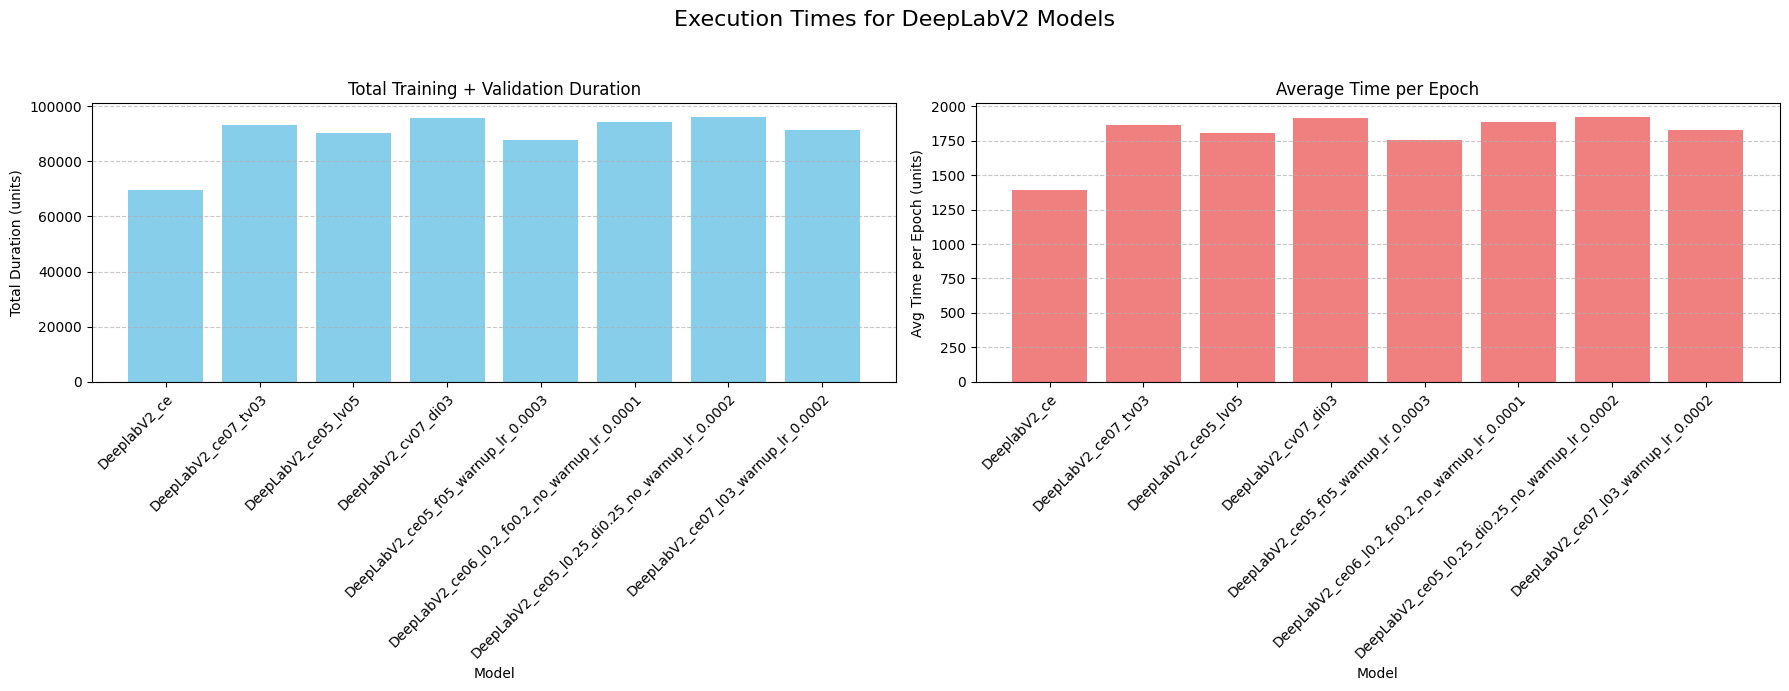

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os


# Data structures to store results
time_metrics = []
trade_off_data = []

print("Processing execution times and mIoU for analysis...")

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]
    
    try:
        df = pd.read_csv(file_name)

        # Check for required columns for time calculation (now just 'Runtime')
        required_time_col = 'Runtime'
        
        # Calculate total and average time
        if required_time_col in df.columns:
            # Sum all values in the 'Runtime' column to get the total duration
            total_duration_sum = df[required_time_col].sum()
            num_epochs = df['epoch'].max() if not df.empty else 0
            
            # Calculate average time per epoch
            avg_time_per_epoch = total_duration_sum / num_epochs if num_epochs > 0 else 0

            time_metrics.append({
                'Model': model_name,
                'Total Duration': total_duration_sum,
                'Avg Time per Epoch': avg_time_per_epoch
            })
            
            # Extract final validation mIoU for trade-off analysis
            # Prioritize 'val_mIoU_final', fallback to 'val_mIoU' of the last epoch
            final_val_mIoU = None
            if 'val_mIoU_final' in df.columns:
                final_val_mIoU = df['val_mIoU_final'].iloc[-1]
            elif 'val_mIoU' in df.columns: 
                final_val_mIoU = df['val_mIoU'].iloc[-1]
            else:
                print(f"Warning: Neither 'val_mIoU_final' nor 'val_mIoU' found for '{file_name}'. Cannot assess accuracy for trade-off.")

            if final_val_mIoU is not None:
                trade_off_data.append({
                    'Model': model_name,
                    'Total Duration': total_duration_sum,
                    'Final Val mIoU': final_val_mIoU
                })
        else:
            print(f"Skipping time metrics for '{file_name}': Missing '{required_time_col}' column.")
            
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found. Skipping.")
    except Exception as e:
        print(f"An error occurred while processing '{file_name}': {e}. Skipping.")

# Convert to DataFrame for easier plotting and display
df_time_metrics = pd.DataFrame(time_metrics)
df_trade_off = pd.DataFrame(trade_off_data)

# --- Part 1: Plotting Total and Average Times ---
if not df_time_metrics.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle("Execution Times for DeepLabV2 Models", fontsize=16)

    # Total Duration Plot
    axes[0].bar(df_time_metrics['Model'], df_time_metrics['Total Duration'], color='skyblue')
    axes[0].set_title("Total Training + Validation Duration", fontsize=12)
    axes[0].set_xlabel("Model", fontsize=10)
    axes[0].set_ylabel("Total Duration (units)", fontsize=10) # Unit depends on your CSV (e.g., seconds, minutes)
    axes[0].tick_params(axis='x', rotation=0) # Rimosso ha='right' da tick_params
    # Imposta la rotazione e l'allineamento delle etichette separatamente
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Average Time per Epoch Plot
    axes[1].bar(df_time_metrics['Model'], df_time_metrics['Avg Time per Epoch'], color='lightcoral')
    axes[1].set_title("Average Time per Epoch", fontsize=12)
    axes[1].set_xlabel("Model", fontsize=10)
    axes[1].set_ylabel("Avg Time per Epoch (units)", fontsize=10)
    axes[1].tick_params(axis='x', rotation=0) # Rimosso ha='right' da tick_params
    # Imposta la rotazione e l'allineamento delle etichette separatamente
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent main title overlap
    plt.show()
else:
    print("No time metrics data available for plotting.")

